#### Summary:
We've settled on final methods for both RNA and ATAC trait associations and I'm making final versions of notebooks for these. In this notebook I'll implement the final ATAC trait associations! Unlike with RNA, where we find major differences between the gene expression counts data, the ATAC data looks much more comparable between the two datasets. Thus, here we'll run DESeq on both datasets combined, including covariates for dataset and sequencing depth. I'm still working on downstream analyses with peaks, but I'll try and add them here as we figure them out.

In [1]:
suppressMessages(library(dplyr)) 
suppressMessages(library(Matrix)) 
suppressMessages(library(data.table))
suppressMessages(library(future)) 
suppressMessages(library(stringr))
suppressMessages(library(stringi))
suppressMessages(library(readr))
#suppressMessages(library(meta))

suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr)) 
suppressMessages(library(ggrepel))
suppressMessages(library(RColorBrewer))
suppressMessages(library(shadowtext))
suppressMessages(library(forcats))

#suppressMessages(library(DESeq2))
#suppressMessages(library(fgsea))
suppressMessages(library(parallel))
#suppressMessages(library(bettermc))
#suppressMessages(library(qvalue))

suppressMessages(library(enrichR))
suppressMessages(library(rWikiPathways))
suppressMessages(library(fgsea))

# Basic Inputs

In [2]:
alberta_samples <- c('R207','R217','R218','R221','R223',
                      'R226','R228','R234','R237','R238',
                      'R246', 'R247', 'R275', 'R284', 
                      'R290', 'R292', 'R316', 'R317', 'R319',
                      'R325','R326','R327','R332',
                      'R353','R354','R362','R363','R364')

hpap_samples_atac <- c('HPAP-035','HPAP-036','HPAP-039','HPAP-040','HPAP-044',
                       'HPAP-045','HPAP-047','HPAP-049','HPAP-050','HPAP-052',
                       'HPAP-053','HPAP-054','HPAP-056','HPAP-059','HPAP-063',
                       'HPAP-067','HPAP-069','HPAP-072','HPAP-075','HPAP-077',
                       'HPAP-080','HPAP-092','HPAP-099','HPAP-101','HPAP-103',
                       'HPAP-104','HPAP-105')
length(hpap_samples_atac)

[1] 27

In [15]:
outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations'
deseq_outdir <- file.path(outdir,'ATAC','DESeq')
links_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/method_overlaps/231211_links_summary'

In [4]:
#joint_celltypes <- c('beta', 'alpha', 'delta', 'gamma', 'acinar','ductal', 'endothelial', 'immune','stellate')
#only run ATAC on larger cell types bc of data sparsity
joint_celltypes <- c('beta', 'alpha', 'delta', 'gamma', 'acinar','ductal')

In [5]:
joint_celltypes
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B',
            '#F5DE6C', '#752BBA', '#F598C9','#FDBB84')
names(colors) <- joint_celltypes
colors

[1] "beta"   "alpha"  "delta"  "gamma"  "acinar" "ductal"

beta     alpha     delta     gamma    acinar    ductal      <NA>      <NA> 
"#3F98E0" "#F51646" "#E39E14" "#A1D99B" "#09850B" "#F5DE6C" "#752BBA" "#F598C9" 
     <NA> 
"#FDBB84"

In [6]:
traits <- c('scaled_age','scaled_BMI','scaled_HbA1c','sex')

In [7]:
link_methods <- c('hm_abc_cic','hm_abc','hm_cic','abc_cic','hm','abc','cic')
no_cic_link_methods <- c('hm_abc_cic','hm_abc','hm_cic','abc_cic','hm','abc')
overlap_link_methods <- c('hm_abc_cic','hm_abc','hm_cic','abc_cic')

In [8]:
databases <- c('GO_Molecular_Function_2021', 'GO_Cellular_Component_2021',
               'KEGG_2021_Human', 'GO_Biological_Process_2021')

databases2 <- c('GO_Molecular_Function_2023', 'GO_Cellular_Component_2023',
               'KEGG_2021_Human', 'GO_Biological_Process_2023', 'MSigDB_Hallmark_2020')

# 1. Pathway enrichment on DESeq results with GREAT Analysis
Options: 
- GREAT analysis (works really well on website, but that's too manual) --> got the weird web submission thing to work!
- LOLA (just TF databases)
- WhichTF (also just TF focused)

## Prepare files for GREAT and submit jobs via HTTP web submission

In [5]:
great_dir <- file.path(outdir,'ATAC/GREAT_p0.01')
aws_dir <- 'hmummey/GREAT_websubmit/240625_p01'

In [7]:
bg_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/240304_union_peaks/celltype_union_peaks'

# First make named cell type union peak reference files and upload to AWS
for(celltype in joint_celltypes){
    #read in celltype peaks file and remake name col to be peak coords
    ct_fp1 <- file.path(bg_dir,sprintf('%s.union_peaks.bed',celltype))
    ct_peaks <- read.table(ct_fp1, sep='\t')
    ct_peaks$V4 <- paste(ct_peaks$V1, ct_peaks$V2, ct_peaks$V3, sep='-')
    
    #write out to new file with only autosomal peaks
    ct_peaks_auto <- subset(ct_peaks, !grepl('chrX|chrY',V1))
    fp_name <- sprintf('%s_union_peaks.bed',celltype)
    ct_fp2 <- file.path(great_dir,'ct_peaks',fp_name)
    write.table(ct_peaks_auto, ct_fp2, sep='\t', row.names=F, col.names=F, quote=F)

    #upload file to AWS directory I prepared
    system(sprintf('aws s3 cp %s s3://gaulton-lab-ucsc/%s/%s', ct_fp2, aws_dir, fp_name))   
}

In [8]:
### Function to prep associations file for GREAT, upload it to AWS and submit the job to their web service
### PVALUE CUTOFF VERSION
run_GREAT2 <- function(celltype, trait, dir, deseq_dir, great_dir, aws_dir, script_fp, min_peaks=5, p_cutoff=0.01){
    #create a bed file of sig results for input dir
    fp <- file.path(deseq_outdir,trait,sprintf('ATAC_deseq_v4.%s.%s.tsv',trait, celltype))
    df <- read.table(fp, sep='\t', header=1)
    if (dir=='up') df_sig_dir <- subset(df, pvalue<p_cutoff & log2FoldChange > 0)
    if (dir=='down') df_sig_dir <- subset(df, pvalue<p_cutoff & log2FoldChange < 0)    
    
    sig_peaks <- row.names(df_sig_dir)
    sig_df <- as.data.frame(str_split_fixed(sig_peaks,'-',3))
    sig_df$V4 <- sig_peaks
    
    #if enough sig peaks, proceed
    if(dim(sig_df)[1] >= min_peaks){
        out_fp <- file.path(great_dir,'sig_assoc_peaks',trait,sprintf('%s_%s_sig_peaks_%s.bed', celltype, trait, dir))
        write.table(sig_df, out_fp, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)

        #upload assoc file to AWS
        sig_prefix <- sprintf('%s_%s_sig_peaks_%s.bed',celltype, trait, dir)
        system(sprintf('aws s3 cp %s s3://gaulton-lab-ucsc/%s/%s', out_fp, aws_dir, sig_prefix))   

        #build and run the wget command to send these to the GREAT webserver
        results_fp <- file.path(great_dir,'results',trait,sprintf('%s_%s_%s_GREAT_webserver_results.tsv',celltype,trait,dir))
        request_name <- paste(celltype,trait,dir,sep='_')
        request_url <- sprintf('https://s3-us-west-2.amazonaws.com/gaulton-lab-ucsc/%s/%s',aws_dir, sig_prefix)
        bg_url <- sprintf('https://s3-us-west-2.amazonaws.com/gaulton-lab-ucsc/%s/%s_union_peaks.bed',aws_dir, celltype)
        request_url_http <- gsub(':','%3A', gsub('/','%2F',request_url))
        bg_url_http <- gsub(':','%3A', gsub('/','%2F',bg_url))

        #cmd inputs: fp to save results to, name for request (doesn't matter), input peaks AWS url HTTP format, background peaks AWS url HTTP format
        cmd <- sprintf('wget -O %s "http://bejerano.stanford.edu/great/public/cgi-bin/greatStart.php?outputType=batch&requestSpecies=hg38&requestName=%s&requestSender=Client+A&requestURL=%s&bgURL=%s"',results_fp,request_name,request_url_http,bg_url_http)
        #running this from jupyter is getting a bit weird (maybe adds weird \ to the wget statement?)
        #gonna try writing the commands to a file instead and run from the terminal -- works :)
        write(cmd, script_fp, append=TRUE)
        write('sleep 1m', script_fp, append=TRUE) #only supposed to submit one job every minute
    } else {
        print(sprintf('Not enough sig peaks for %s and %s %s associations (n=%s)',celltype, trait, dir, dim(sig_df)[1]))
    }
}

In [13]:
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
script_fp <- file.path(great_dir,'240625_GREAT_web_submissions.sh')

for(celltype in joint_celltypes){
    for(trait in traits){
        for(dir in c('up','down')){
             run_GREAT2(celltype, trait, dir, deseq_outdir, great_dir, aws_dir, script_fp)           
        }
    }
}

Before writing to the script, touch the file and add the appropriate shebang to the top (I use `#!/bin/bash`), then after writing all the commands to it run the script from a screen with `bash $script_fp`

## Plot summaries of pathway enrichment results
Ontology options:
- All Ontologies (no subsetting)
- Ensembl Genes
- GO Biological Process
- GO Cellular Component 
- GO Molecular Function
- Human Phenotype
- Mouse Phenotype 
- Mouse Phenotype Single KO 

In [14]:
### Function to plot summaries of GREAT enrichment results (ALL or specific ontology sets)
plot_great_summary <- function(celltypes, traits, results_dir, ontology, colors, padj_cutoff=0.1){
    #summarize enrichments (read in both up and down results)
    summary_df_up <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(results_dir, trait, sprintf('%s_%s_up_GREAT_webserver_results.tsv', celltype, trait))
            #check if association was run before continuing!
            if(file.exists(fp)){
                df_pre <- suppressMessages(head(vroom::vroom(fp, skip=3),-10))
                colnames(df_pre)[1] <- 'Ontology'
                if(ontology != 'All Ontologies'){
                    df <- subset(df_pre,Ontology==ontology)
                } else {
                    df <- df_pre
                }
                num_sig <- c(num_sig, dim(df[df$HyperFdrQ < padj_cutoff,])[1])
            } else {
                num_sig <- c(num_sig, 0)
            }
        }
        summary_df_up <- rbind(summary_df_up, num_sig)
    }
    
    summary_df_down <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(results_dir, trait, sprintf('%s_%s_down_GREAT_webserver_results.tsv', celltype, trait))
            #check if association was run before continuing!
            if(file.exists(fp)){
                df_pre <- suppressMessages(head(vroom::vroom(fp, skip=3),-10))
                colnames(df_pre)[1] <- 'Ontology'
                if(ontology != 'All Ontologies'){
                    df <- subset(df_pre,Ontology==ontology)
                } else {
                    df <- df_pre
                }
                num_sig <- c(num_sig, dim(df[df$HyperFdrQ < padj_cutoff,])[1])
            } else {
                num_sig <- c(num_sig, 0)
            }
        }
        summary_df_down <- rbind(summary_df_down, num_sig)
    }
    #prep data for plotting
    rownames(summary_df_up) <- celltypes
    colnames(summary_df_up) <- traits
    summary_df_up$celltype <- celltypes
    rownames(summary_df_down) <- celltypes
    colnames(summary_df_down) <- traits
    summary_df_down <- -summary_df_down
    summary_df_down$celltype <- celltypes
    data <- rbind(melt(summary_df_up, id.vars='celltype'),melt(summary_df_down, id.vars='celltype'))
    
    #make plot
    options(repr.plot.width=16, repr.plot.height=6)
    p1 <- ggplot(data, aes(fill=celltype, y=value, x=variable)) + 
            geom_bar(position="dodge", stat="identity", width=0.7) + 
            geom_hline(yintercept=0) + 
            labs(x = "Cell type", y='Num sig pathways', color="Cell Type", title=ontology) + 
            scale_fill_manual(values=colors) + 
            theme(axis.text.x=element_text(size=20, vjust=0.5),
                axis.text.y=element_text(size=20, vjust=0.5),
                axis.title.x = element_text(size=25, vjust=-0.35),
                axis.title.y = element_text(size=25, vjust=0.5),
                legend.title = element_blank(),
                legend.text = element_text(size=15),
            plot.title = element_text(size=25, hjust=0.5, face="bold"))
    print(p1)
}

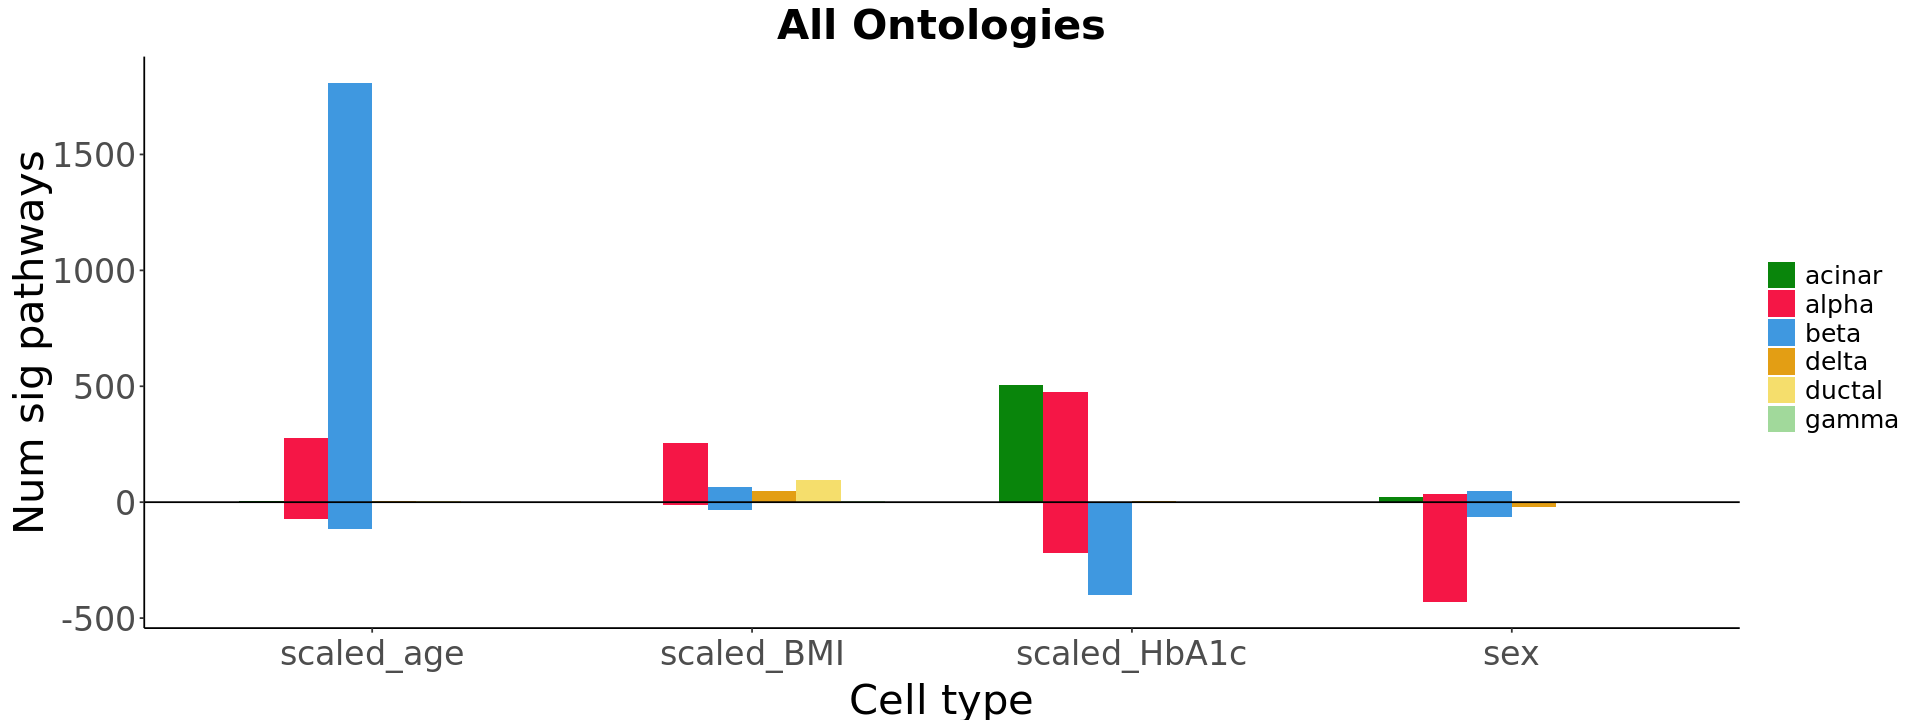

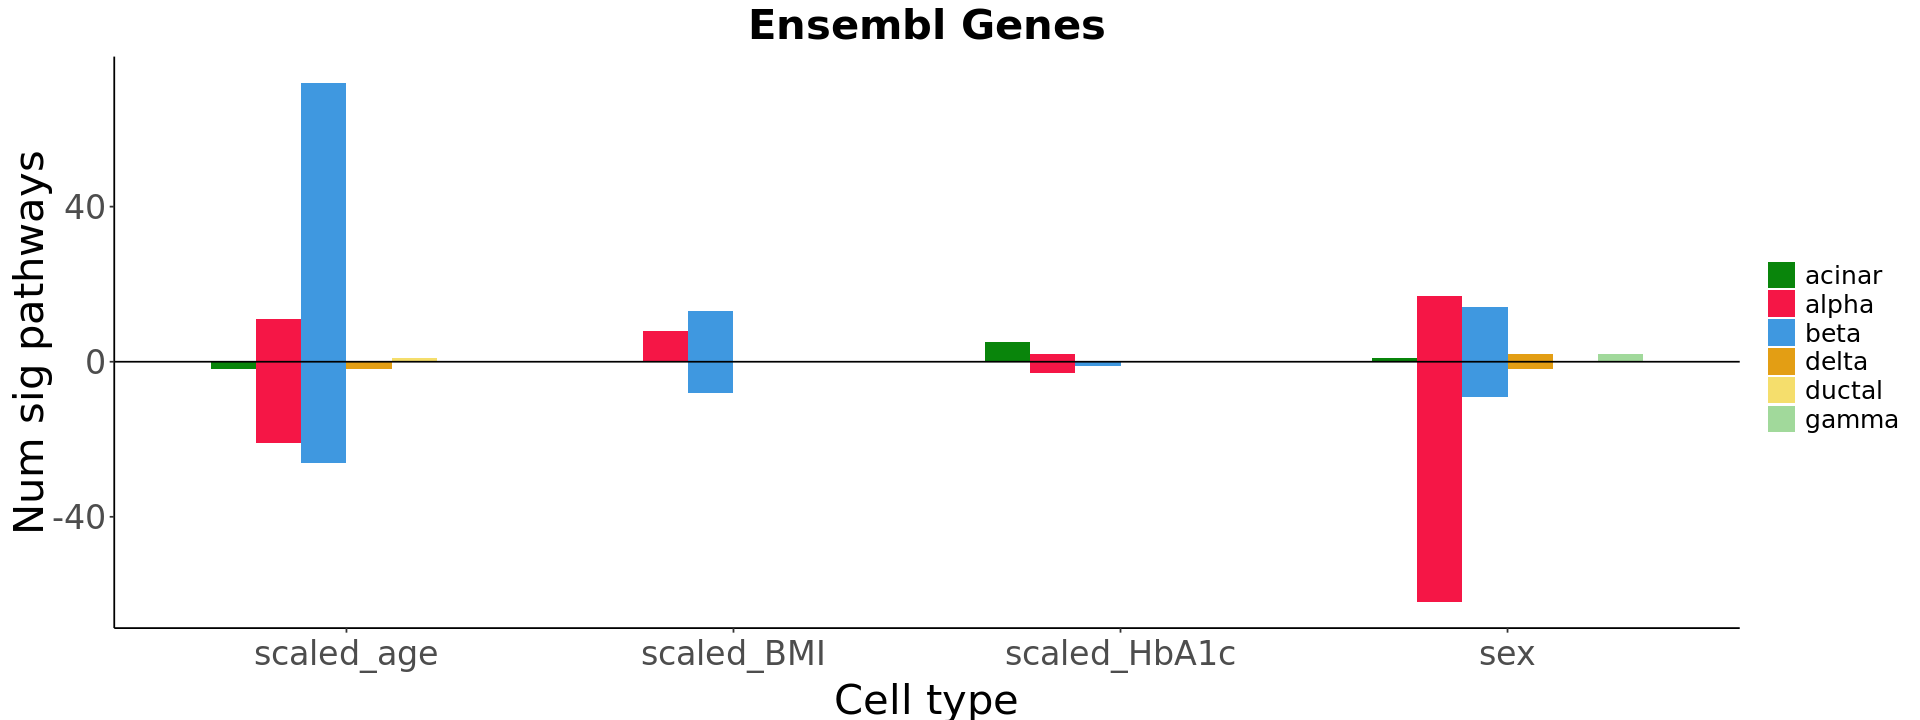

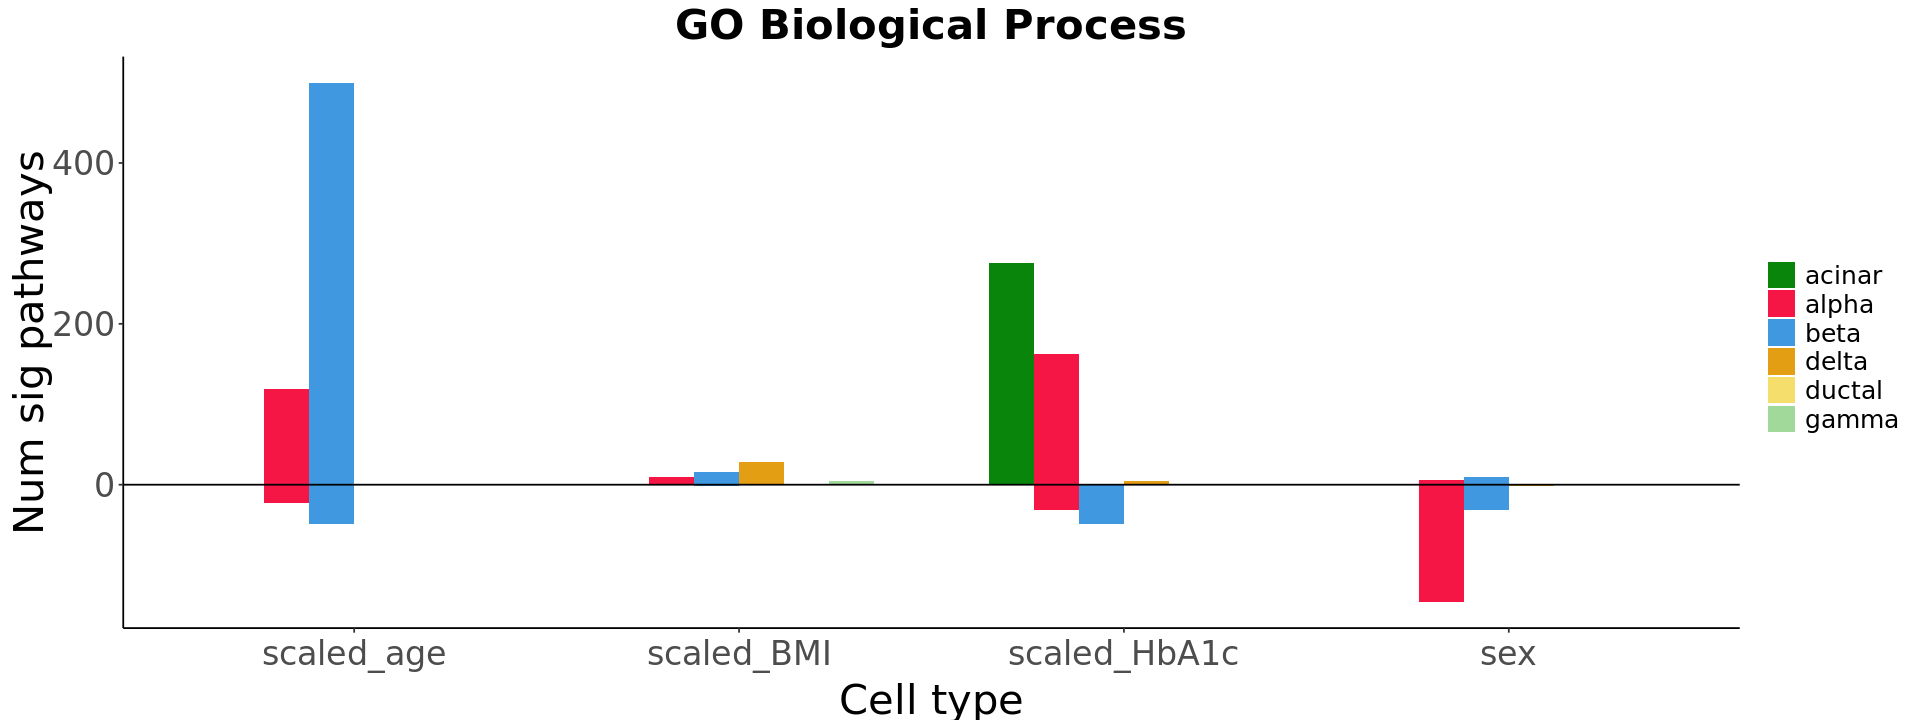

In [18]:
results_dir <- file.path(great_dir,'results')
theme_set(theme_classic())

suppressWarnings(plot_great_summary(joint_celltypes,traits,results_dir,'All Ontologies',colors))
suppressWarnings(plot_great_summary(joint_celltypes,traits,results_dir,'Ensembl Genes',colors))
suppressWarnings(plot_great_summary(joint_celltypes,traits,results_dir,'GO Biological Process',colors))

## Plot top Ontology results
Ontology options:
- All Ontologies (no subsetting)
- Ensembl Genes
- GO Biological Process
- GO Cellular Component 
- GO Molecular Function
- Human Phenotype
- Mouse Phenotype 
- Mouse Phenotype Single KO 

In [19]:
#adapting previous plotting function to just make one plot at a time so I can make a composite plot more easily
#GREAT only tests for enrichcment, so no need to test directions

great_plt <- function(data, trait, dir, color, make_plot=TRUE, numpathways=10, labelthresh=1){
    plt_title <- sprintf('%s GREAT %s pathways (-log10p)', trait, dir)

    #if the GREAT analysis was run make_plot is initially TRUE
    if(make_plot==TRUE){
        #BUT also need to check if anything passed significance
        if(dim(data)[1] > 0){
            #prepare df for plotting
            data$LOG10P <- -log10(data$HyperP)
            data <- data[order(data$HyperP),]
            plt_data <- data[c(1:numpathways),]            
        } else {
            make_plot <- FALSE
        }
    }
        
    #make plot if there is data
    if (make_plot == TRUE){        
        #factor pathways (idk why)
        plt_data$Desc <- factor(plt_data$Desc, levels= plt_data$Desc)
        plt_data$Desc <- fct_rev(plt_data$Desc)

        #make plot 
        plt <- ggplot(plt_data) +
                      geom_col(aes(LOG10P, Desc), fill= color, width = 0.9) + theme_classic() + 
                      scale_x_continuous(limits = c(0, (ceiling(max(plt_data$LOG10P, na.rm = TRUE)) + 0.5)),
                        breaks = seq(0, ceiling(max(plt_data$LOG10P, na.rm = TRUE)), by = 3), 
                        expand = c(0, 0), # The horizontal axis does not extend to either side
                        position = 'top') + # Labels are located on the top
                      scale_y_discrete(expand = expansion(add = c(0, 0.5))) +
                      theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), #change to 0.3 possibly?
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16)) + 
                      geom_shadowtext(
                        data = subset(plt_data, LOG10P >= labelthresh),
                        aes(0, y = Desc, label = Desc),
                        hjust = 0,
                        nudge_x = 0.3,
                        colour = 'white',
                        bg.colour = color,
                        bg.r = 0.2,
                        size = 10) + 
                      geom_text(data = subset(plt_data, LOG10P >= labelthresh),
                        aes(0, y = Desc, label = Desc),
                        hjust = 0,nudge_x = 0.3,colour = 'white',size = 10) +
                      labs(title = '', subtitle = plt_title) +
                      theme(plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))  
        
    #if no data passes sig threshold return blank plot
    } else {
        plt <- ggplot(data) + 
                    geom_blank() + 
                    labs(title = '', subtitle = plt_title) +
                    theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), #change to 0.3 possibly?
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16),
                        plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))
    }
    return(plt)
}

In [20]:
### Function to use my adapted version of Ruth's pathway enrichment plots on the GREAT results
make_ct_great_plots <- function(celltype, traits, ontology, colors, padj_cutoff=0.1){
    plot_list <- list()
    
    #set up up/down colors
    ct_colors <- list()
    ct_colors[['up']] <- colors[[celltype]]
    ct_colors[['down']] <- colorRampPalette(colors = c('black',colors[[celltype]]))(4)[3]
    
    for (trait in traits){
        for (dir in c('up','down')){
            fp <- file.path(results_dir, trait, sprintf('%s_%s_%s_GREAT_webserver_results.tsv', celltype, trait, dir))
            #check if association was run before continuing!
            if(file.exists(fp)){
                df_pre <- suppressMessages(head(vroom::vroom(fp, skip=3),-10))
                colnames(df_pre)[1] <- 'Ontology'
                df <- subset(df_pre,Ontology==ontology)
                df_sig <- subset(df, HyperFdrQ < padj_cutoff)    
                make_plot <- TRUE
            } else {
                make_plot <- FALSE
                df_sig <- df
            }    
            # Call newly adapted version Ruth's function to make up and down plots separately
            plt <- great_plt(df_sig, trait, dir, ct_colors[[dir]], make_plot)
            plot_list[[paste(trait,dir,sep='_')]] <- plt
        }
    }
    #make composite plot
    options(repr.plot.width = 32, repr.plot.height=10)
    fig <- ggarrange(plotlist = plot_list, nrow=2, ncol=4)
    fig <- annotate_figure(fig, top=text_grob(sprintf("GREAT %s pathways for %s cells (DESeq phenotype associations)", ontology, celltype),
                           color = 'black', face='bold', size=25))
    print(fig)
    
}


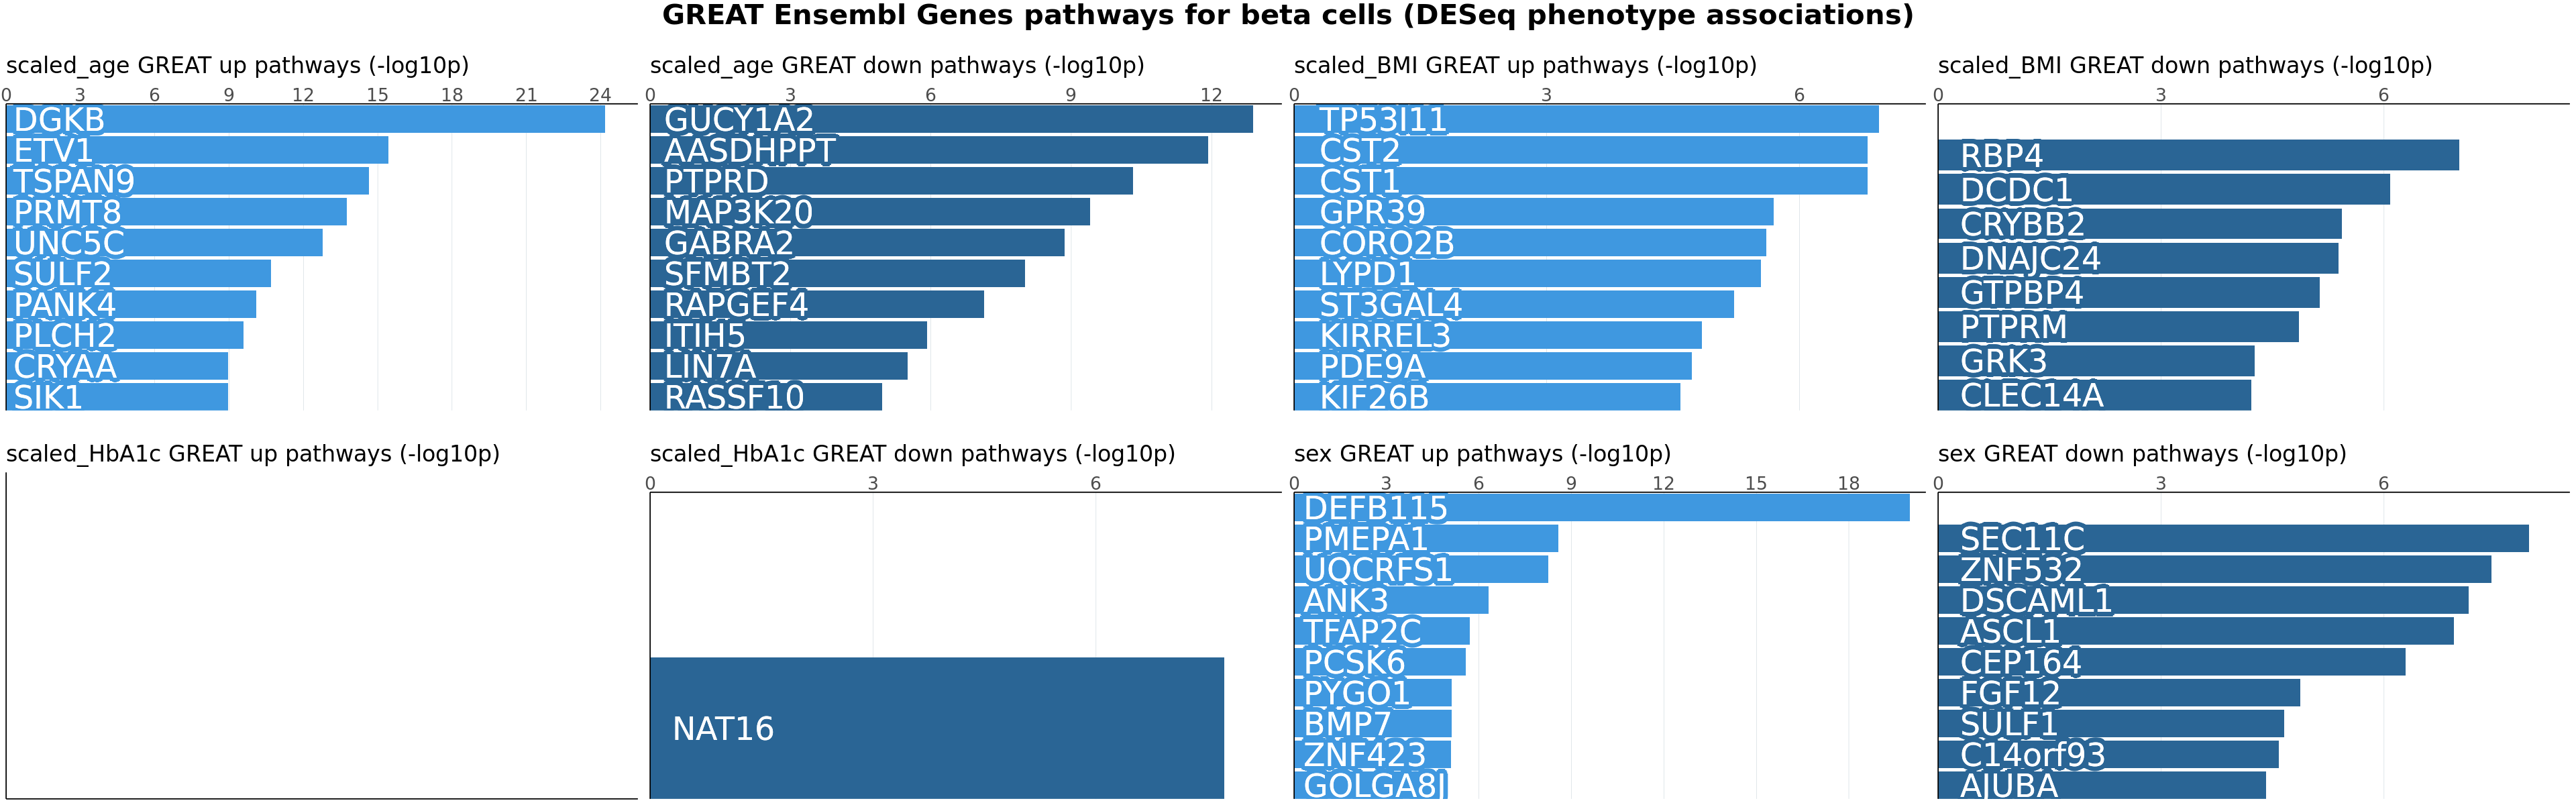

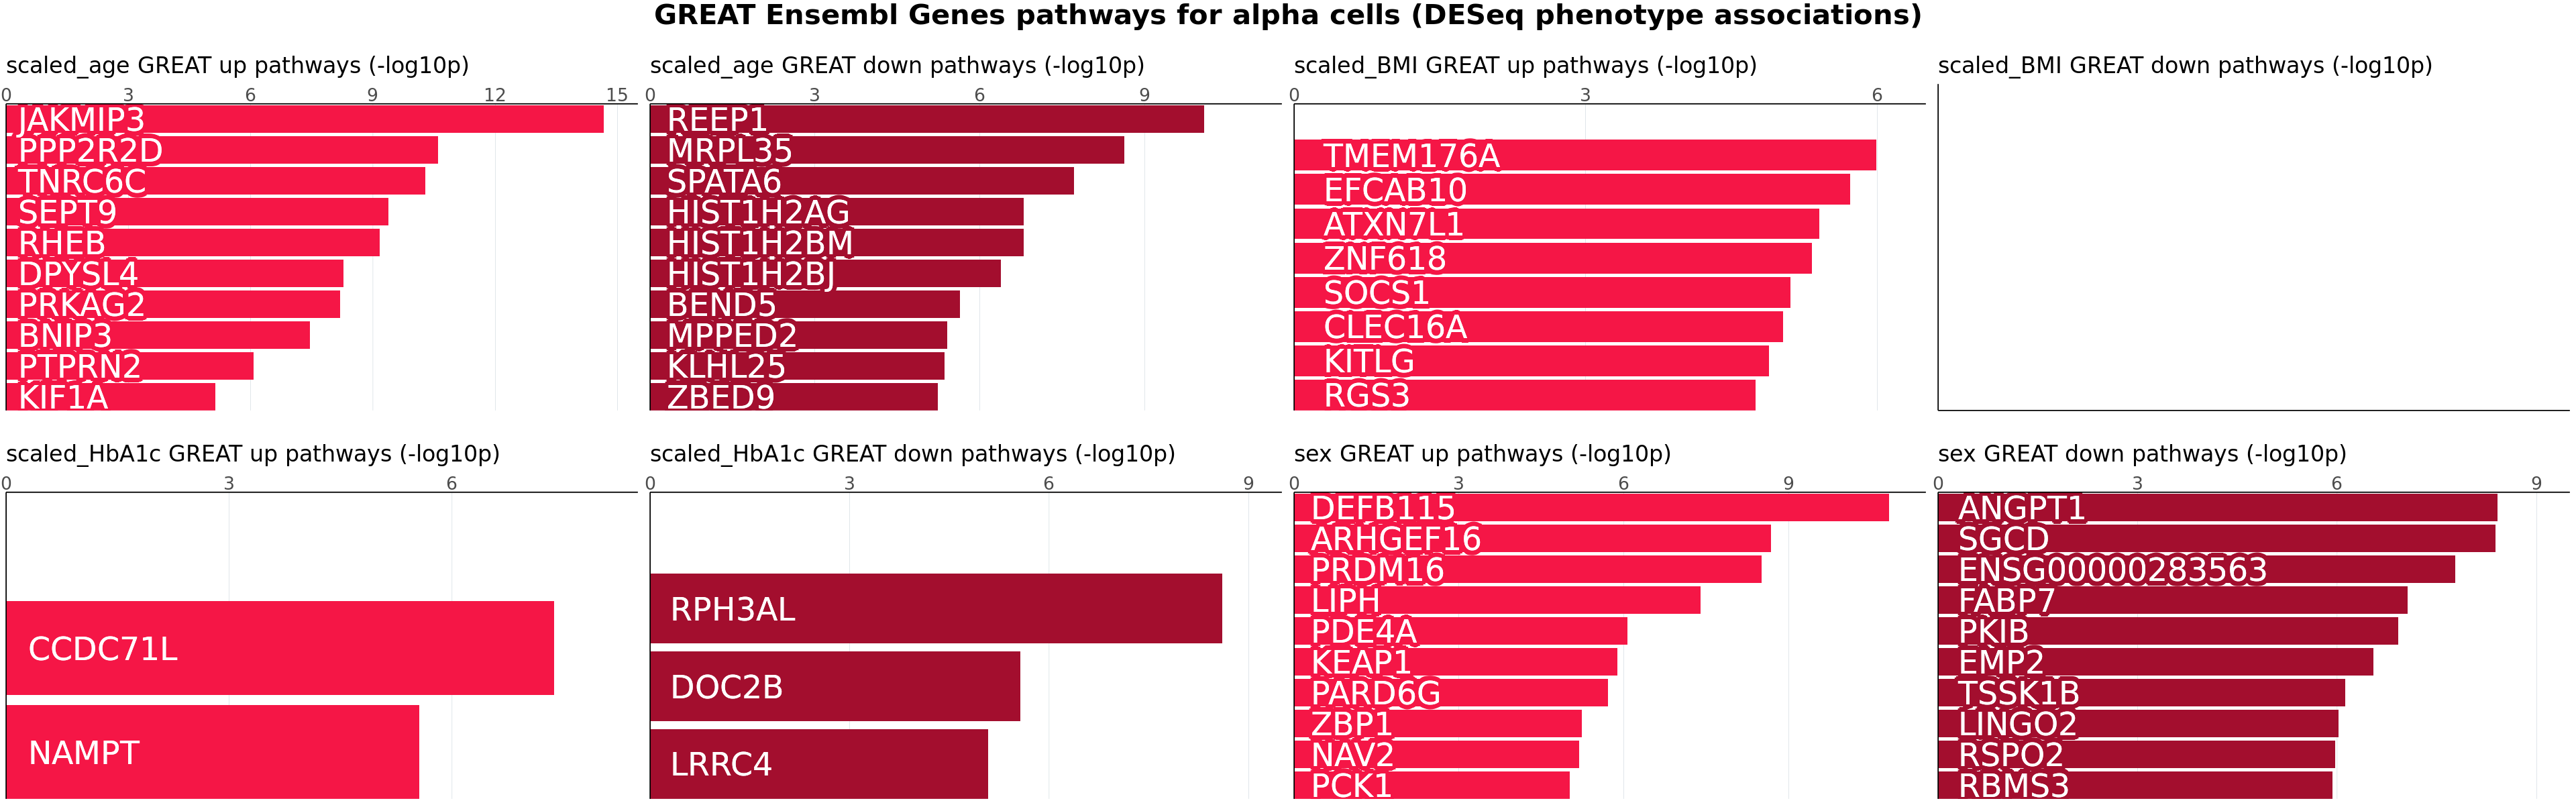

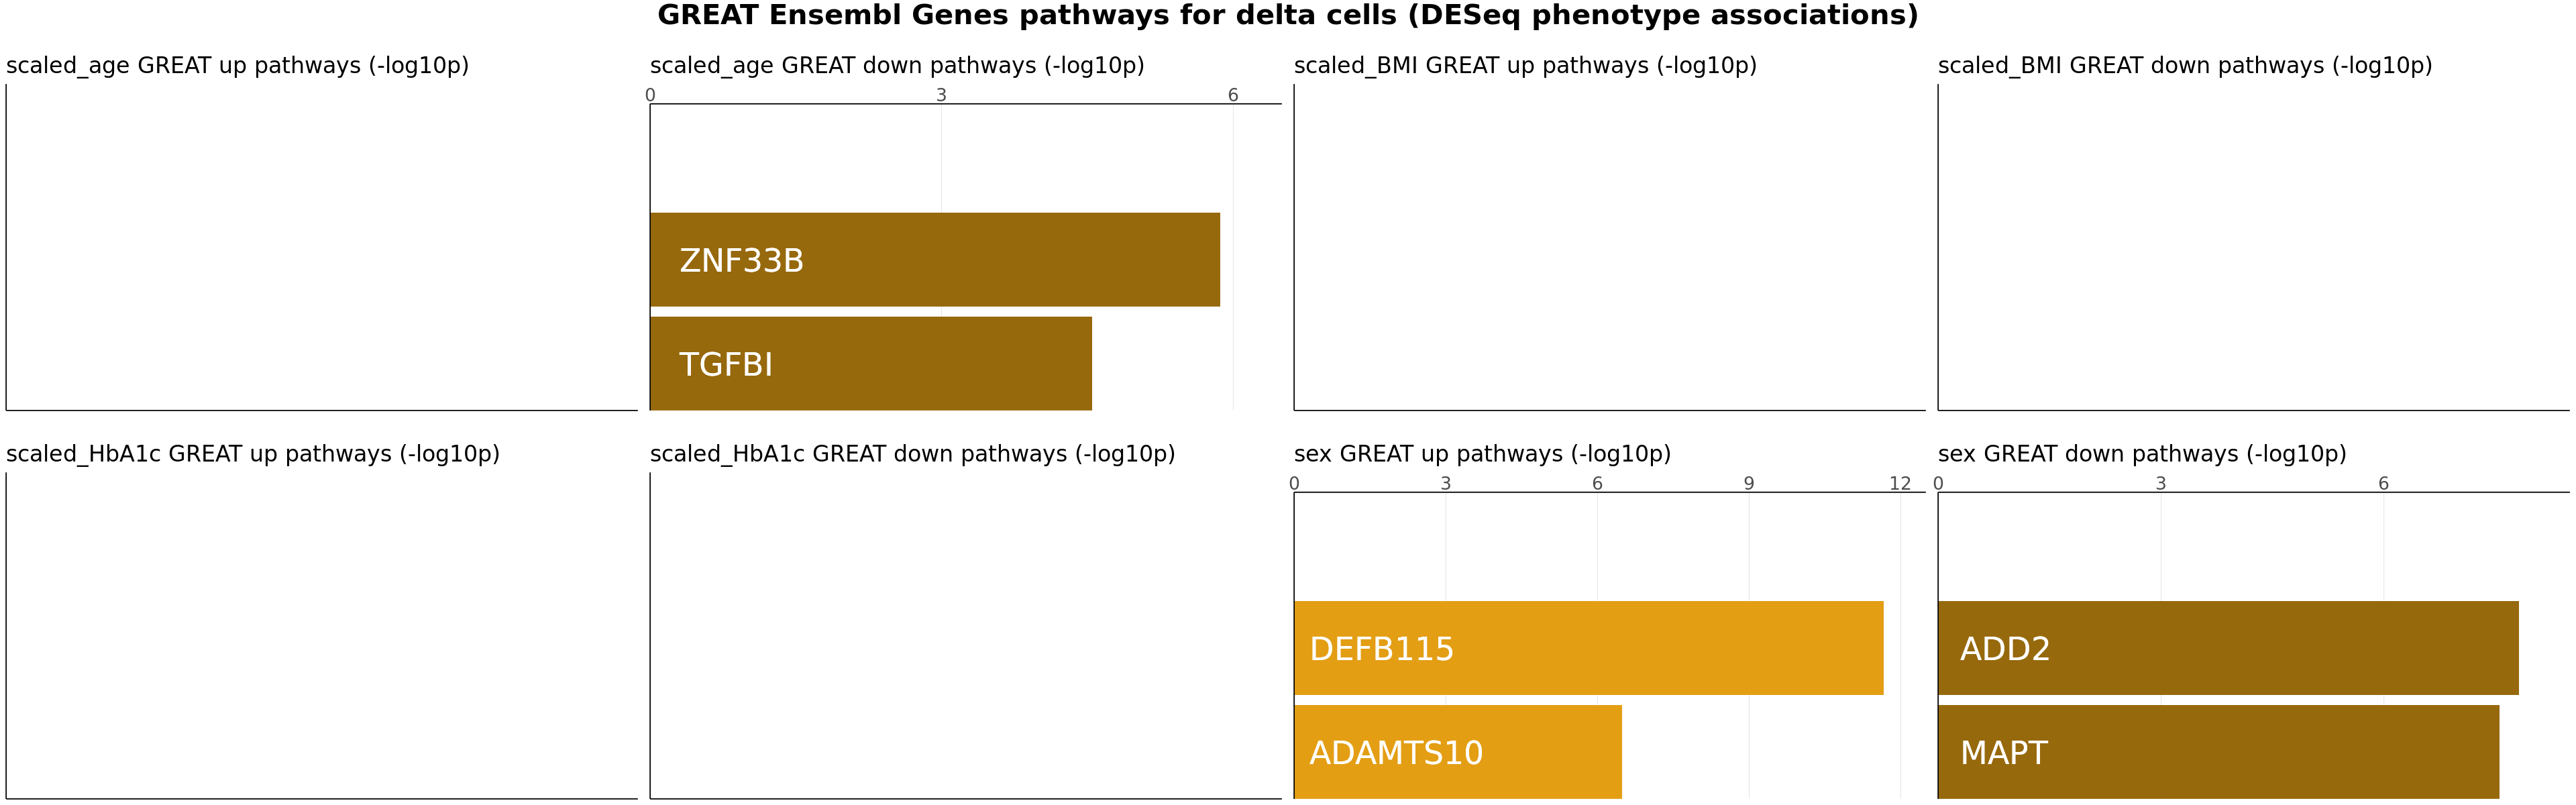

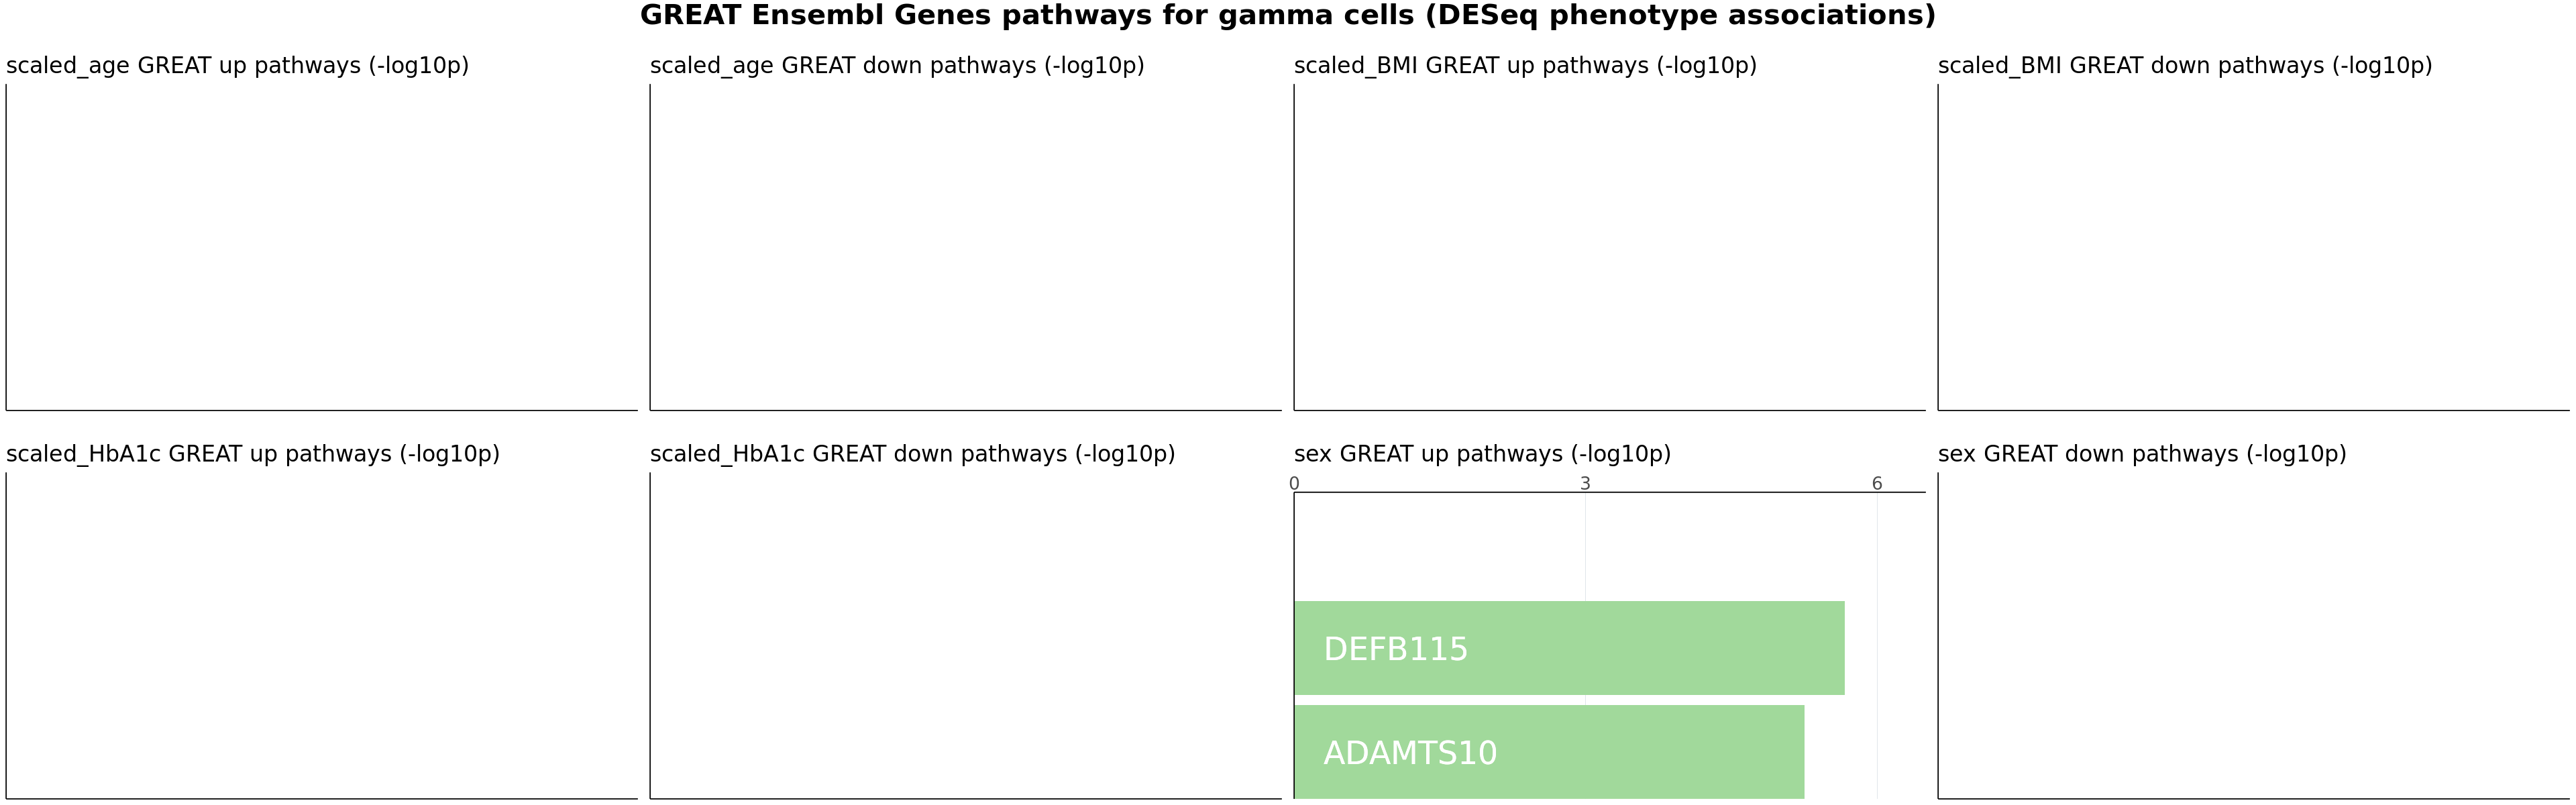

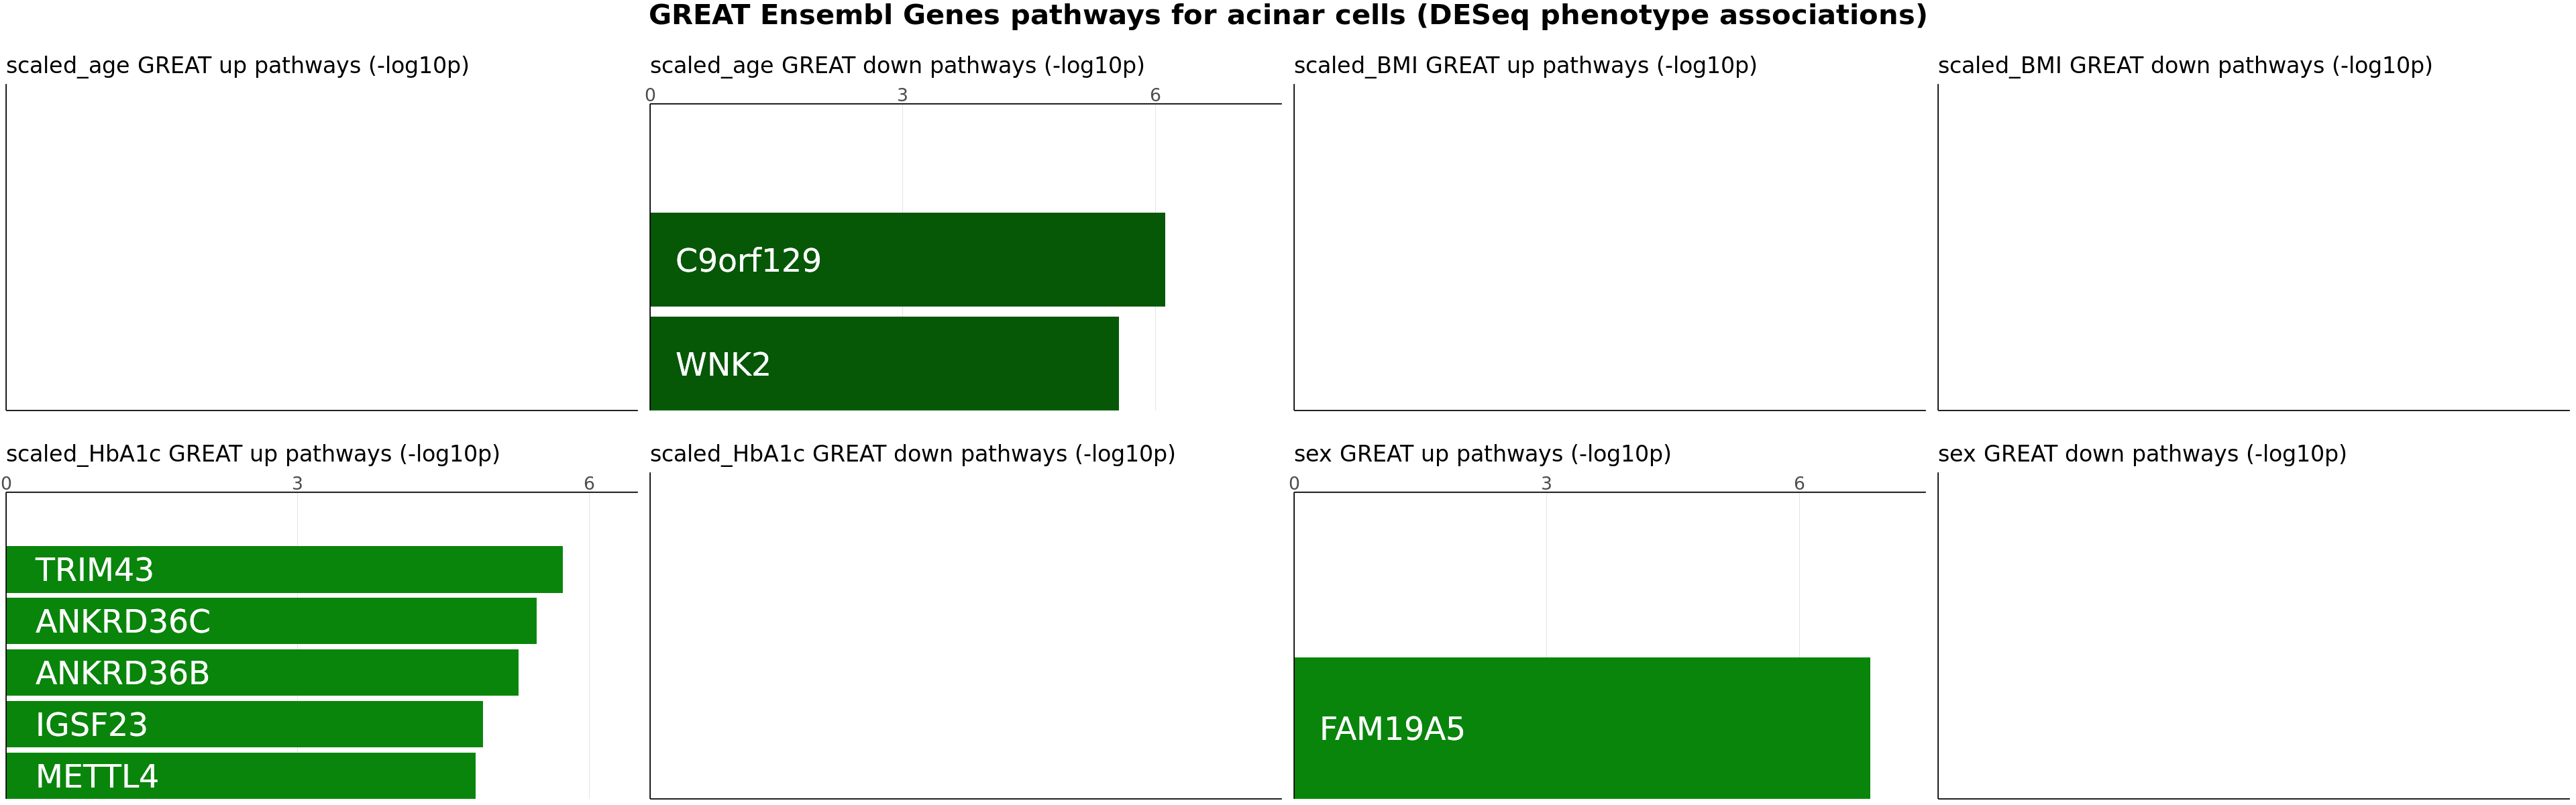

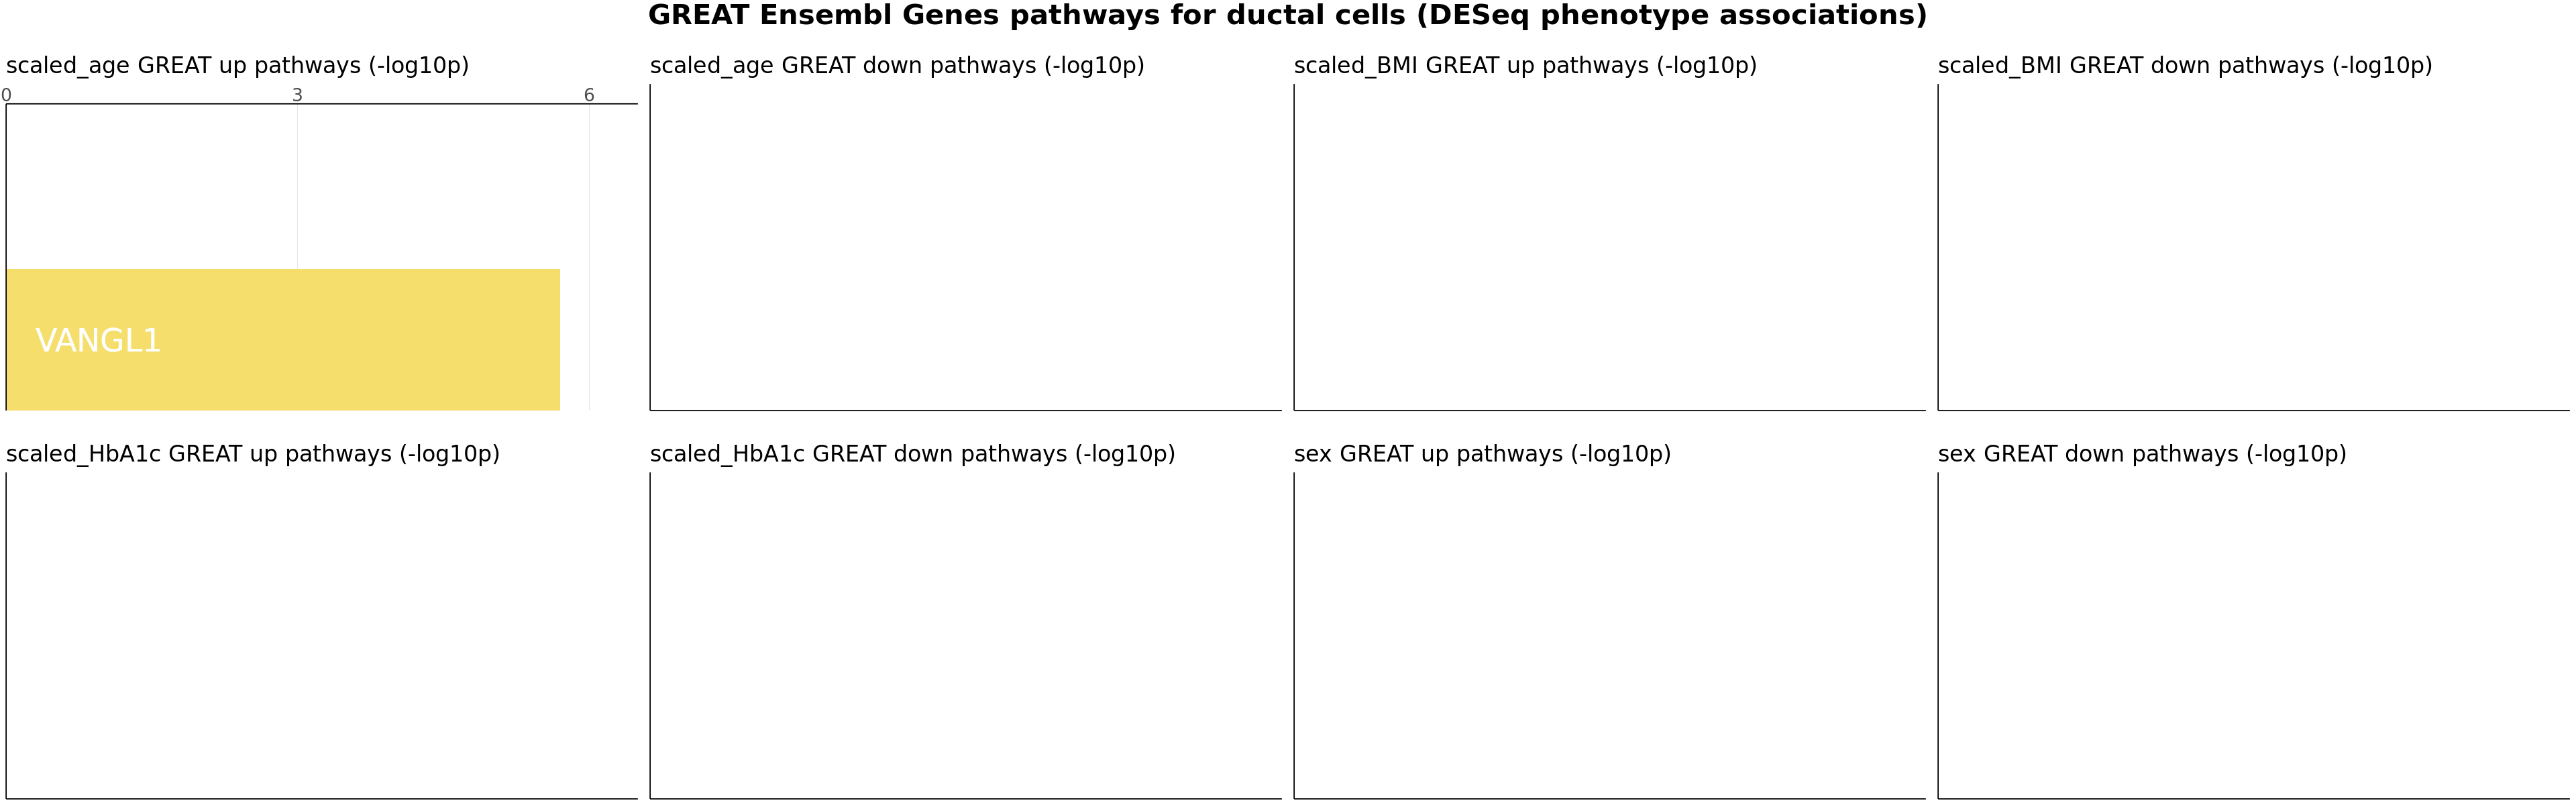

In [23]:
for (celltype in joint_celltypes){
    suppressWarnings(make_ct_great_plots(celltype, traits, 'Ensembl Genes', colors, 0.1))
}

# 2. Motif enrichment with HOMER

Mei's code: "I have a very quick "script" that reads through a tab-delimited file where each line is in the format target_peaks.bed </t> background_peaks.bed </t> output_dir_name , but it does reference the installation path I have on the Gatsby home server currently. For some reason, my HOMER behaves differently in a screen (due to some kind of system differences between our server and the screen system, apparently?) so I have been running it in a terminal window when I am somewhere I won't be disconnected."
```
#!/bin/sh
while IFS= read -r line 
do
        sites=$( echo "$line" | cut -f 1 )
        bgsites=$( echo "$line" | cut -f 2 )
        out_dir=$( echo "$line" | cut -f 3)
        
        perl /home/mokino/scripts/bin/findMotifsGenome.pl "$sites" hg38 "$out_dir" -bg "$bgsites" -size 200 -p 20 -bits -preparse -preparsedDir /nfs/lab/tmp
done < "$1"
```


Alternative: WhichTF
- https://bitbucket.org/bejerano/whichtf/src/master/
- https://bitbucket.org/bejerano/whichtf_scripts/src/master/

Brief bash test of HOMER (can use the GREAT inputs)

```
sites=/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/GREAT/sig_assoc_peaks/scaled_age/beta_scaled_age_sig_peaks_up.bed
bgsites=/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/GREAT/ct_peaks/beta_union_peaks.bed
out_dir=/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER_test

#run on ophelia
perl /home/hmummey/homer/bin/findMotifsGenome.pl "$sites" hg38 "$out_dir" -bg "$bgsites" -size 200 -p 20 -bits -preparse -preparsedDir /nfs/lab/tmp
#seems to be working, but probably need to pipe outputs into a log file bc there's a lot
```

In [8]:
### Function to run HOMER on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
run_HOMER <- function(celltype, trait, dir, great_dir, homer_dir, script_fp){
    #check if there are enough sig results for the association in the great_dir
    bed_fp <- file.path(great_dir, 'sig_assoc_peaks', trait, sprintf('%s_%s_sig_peaks_%s.bed', celltype, trait, dir))
    
    if(file.exists(bed_fp)){
        #set up homer code
        bg_fp <- file.path(great_dir, 'ct_peaks', sprintf('%s_union_peaks.bed',celltype))
        out_dir <- file.path(homer_dir, trait, paste(celltype,dir,sep='_'))
        dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)
        log_fp <- file.path(outdir, 'log_HOMER.txt')
        cmd <- sprintf('perl /home/hmummey/homer/bin/findMotifsGenome.pl %s hg38 %s -bg %s -size 200 -p 20 -bits > %s', bed_fp, out_dir, bg_fp, log_fp)
        write(cmd, script_fp, append=TRUE)
    }
}

In [10]:
great_dir <- file.path(outdir,'ATAC/GREAT')

In [11]:
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
homer_dir <- file.path(outdir, 'ATAC', 'HOMER')
script_fp <- file.path(homer_dir,'240426_HOMER_commands.sh')

for(celltype in joint_celltypes){
    for(trait in traits){
        for(dir in c('up','down')){
            run_HOMER(celltype, trait, dir, great_dir, homer_dir, script_fp)
        }
    }
}

Run the script in the terminal (in parallel and in a screen)
```
screen -S motifs
cd /nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER
parallel -j 7 < 240426_HOMER_commands.sh
```

## After HOMER is done running parse results and visualize

In [11]:
### Function to parse HOMER results into better format (based on code from Emily)
parse_HOMER_knownResults <- function(celltype, trait, dir, homer_dir){
    homer_fp <- file.path(homer_dir, trait, paste(celltype,dir,sep='_'), 'knownResults.txt')
    if(file.exists(homer_fp)){
        df <- fread(homer_fp)
    
        #select columns of interest and modify names
        df_fin <- copy(df)
        colnames(df_fin) <- c('motif','consensus','pval','log_pval','qval','target_seq_w_motif','perc_target_seq_w_motif','bg_seq_w_motif','perc_bg_seq_w_motif')    
        df_fin$perc_target_seq_w_motif <- gsub("[%]", "", df_fin$perc_target_seq_w_motif) #remove percents
        df_fin$perc_bg_seq_w_motif <- gsub("[%]", "", df_fin$perc_bg_seq_w_motif)
        df_fin <- df_fin %>% select(-c(consensus,target_seq_w_motif,bg_seq_w_motif)) %>%
                    mutate(motif_short=gsub("/.*",'',motif)) %>% mutate(motif_short=gsub("[(].*", "", motif_short)) %>% #shorten motif names to TFs
                    mutate_at(c('perc_target_seq_w_motif','perc_bg_seq_w_motif'),as.numeric) %>% #convert percents to numeric
                    mutate(fc=(perc_target_seq_w_motif-perc_bg_seq_w_motif)/perc_bg_seq_w_motif) %>% #calculate foldchange
                    mutate(l2fc=log2(abs(fc))) #take log2 of foldchange
        #recalc the qvalue with out preferred method
        df_fin$neglog10p <- -log10(df_fin$pval)
        df_fin$padj <- p.adjust(p=df_fin$pval, method='BH', n=nrow(df_fin))

        #write to file non-sig motifs
        out_fp <- file.path(homer_dir,'sig_motifs',sprintf('%s_%s_%s.HOMER_ALL_motifs.bed', celltype, trait, dir))
        write.table(df_fin, out_fp, sep='\t', row.names=FALSE, quote=FALSE)               
        
        #cut to sig motifs and do final reordering
        df_sig <- subset(df_fin, padj < 0.1)
        df_sig <- df_sig %>% select(-c(log_pval,qval)) %>% relocate(c(neglog10p,padj), .after=pval)
        print(paste(homer_fp, dim(df_sig)[1]))

        #write to file
        if(dim(df_sig)[1] > 0){
            out_fp <- file.path(homer_dir,'sig_motifs',sprintf('%s_%s_%s.HOMER_sig_motifs.bed', celltype, trait, dir))
            write.table(df_sig, out_fp, sep='\t', row.names=FALSE, quote=FALSE)               
        }
    }
}

In [13]:
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
homer_dir <- file.path(outdir, 'ATAC', 'HOMER')

for(celltype in joint_celltypes){
    for(trait in traits){
        for(dir in c('up','down')){
            parse_HOMER_knownResults(celltype, trait, dir, homer_dir)
        }
    }
}

[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/scaled_age/beta_up/knownResults.txt 20"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/scaled_age/beta_down/knownResults.txt 2"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/scaled_BMI/beta_up/knownResults.txt 3"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/scaled_BMI/beta_down/knownResults.txt 0"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/scaled_HbA1c/beta_down/knownResults.txt 0"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/sex/beta_up/knownResults.txt 0"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_asso

## Basic summary plots

In [41]:
### summarize sig genes results (plot with up and down as + and -)
summarize_HOMER_sig_motifs <- function(traits, celltypes, deseq_outdir, colors, padj_cutoff=0.1){
    #collect up and down info separately
    summary_df_up <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(homer_dir,'sig_motifs',sprintf('%s_%s_%s.HOMER_sig_motifs.bed', celltype, trait, 'up'))
            if(file.exists(fp)){
                df <- read.table(fp, sep='\t', header=TRUE)
                num_sig <- c(num_sig, dim(df[df$padj < padj_cutoff & df$fc > 0,])[1])                
            } else {
                num_sig <- c(num_sig, 0)
            }
        }
        summary_df_up <- rbind(summary_df_up, num_sig)
    }
    colnames(summary_df_up) <- traits

    summary_df_down <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(homer_dir,'sig_motifs',sprintf('%s_%s_%s.HOMER_sig_motifs.bed', celltype, trait, 'down'))
            if(file.exists(fp)){
                df <- read.table(fp, sep='\t', header=TRUE)
                num_sig <- c(num_sig, dim(df[df$padj < padj_cutoff & df$fc > 0,])[1])                
            } else {
                num_sig <- c(num_sig, 0)
            }
        }
        summary_df_down <- rbind(summary_df_down, num_sig)
    }
    colnames(summary_df_down) <- traits

    #merge up/down dfs into one dataframe
    summary_df_up$celltype <- celltypes
    summary_df_down <- -summary_df_down
    summary_df_down$celltype <- celltypes
    data <- rbind(melt(summary_df_up, id.vars='celltype'), melt(summary_df_down, id.vars='celltype'))

    # Make grouped barplot of desired metadata
    options(repr.plot.width=16, repr.plot.height=8)
    theme_set(
        theme_classic())

    p1 <- ggplot(data, aes(fill=celltype, y=value, x=variable)) + 
            geom_bar(position="dodge", stat="identity", width=0.7) + 
            geom_hline(yintercept=0) + 
            labs(x = "Celltype", y='Num sig motifs', color="Cell Type") + 
            scale_fill_manual(values=colors) + 
            theme(axis.text.x=element_text(size=20, vjust=0.5),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=25, vjust=-0.35),
            axis.title.y = element_text(size=25, vjust=0.5),
            legend.title = element_blank(),
            legend.text = element_text(size=15),
            plot.title = element_text(size=25, hjust=0.5, face="bold"))
    print(p1)
}

In [39]:
joint_celltypes
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B',
            '#F5DE6C', '#752BBA', '#F598C9','#FDBB84')
names(colors) <- joint_celltypes
colors

[1] "beta"   "alpha"  "delta"  "gamma"  "acinar" "ductal"

beta     alpha     delta     gamma    acinar    ductal      <NA>      <NA> 
"#3F98E0" "#F51646" "#E39E14" "#A1D99B" "#09850B" "#F5DE6C" "#752BBA" "#F598C9" 
     <NA> 
"#FDBB84"

Warning message in melt(summary_df_up, id.vars = "celltype"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(summary_df_up). In the next version, this warning will become an error.”
Warning message in melt(summary_df_down, id.vars = "celltype"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(summary_df_down). In the next version, this warning will become an error.”


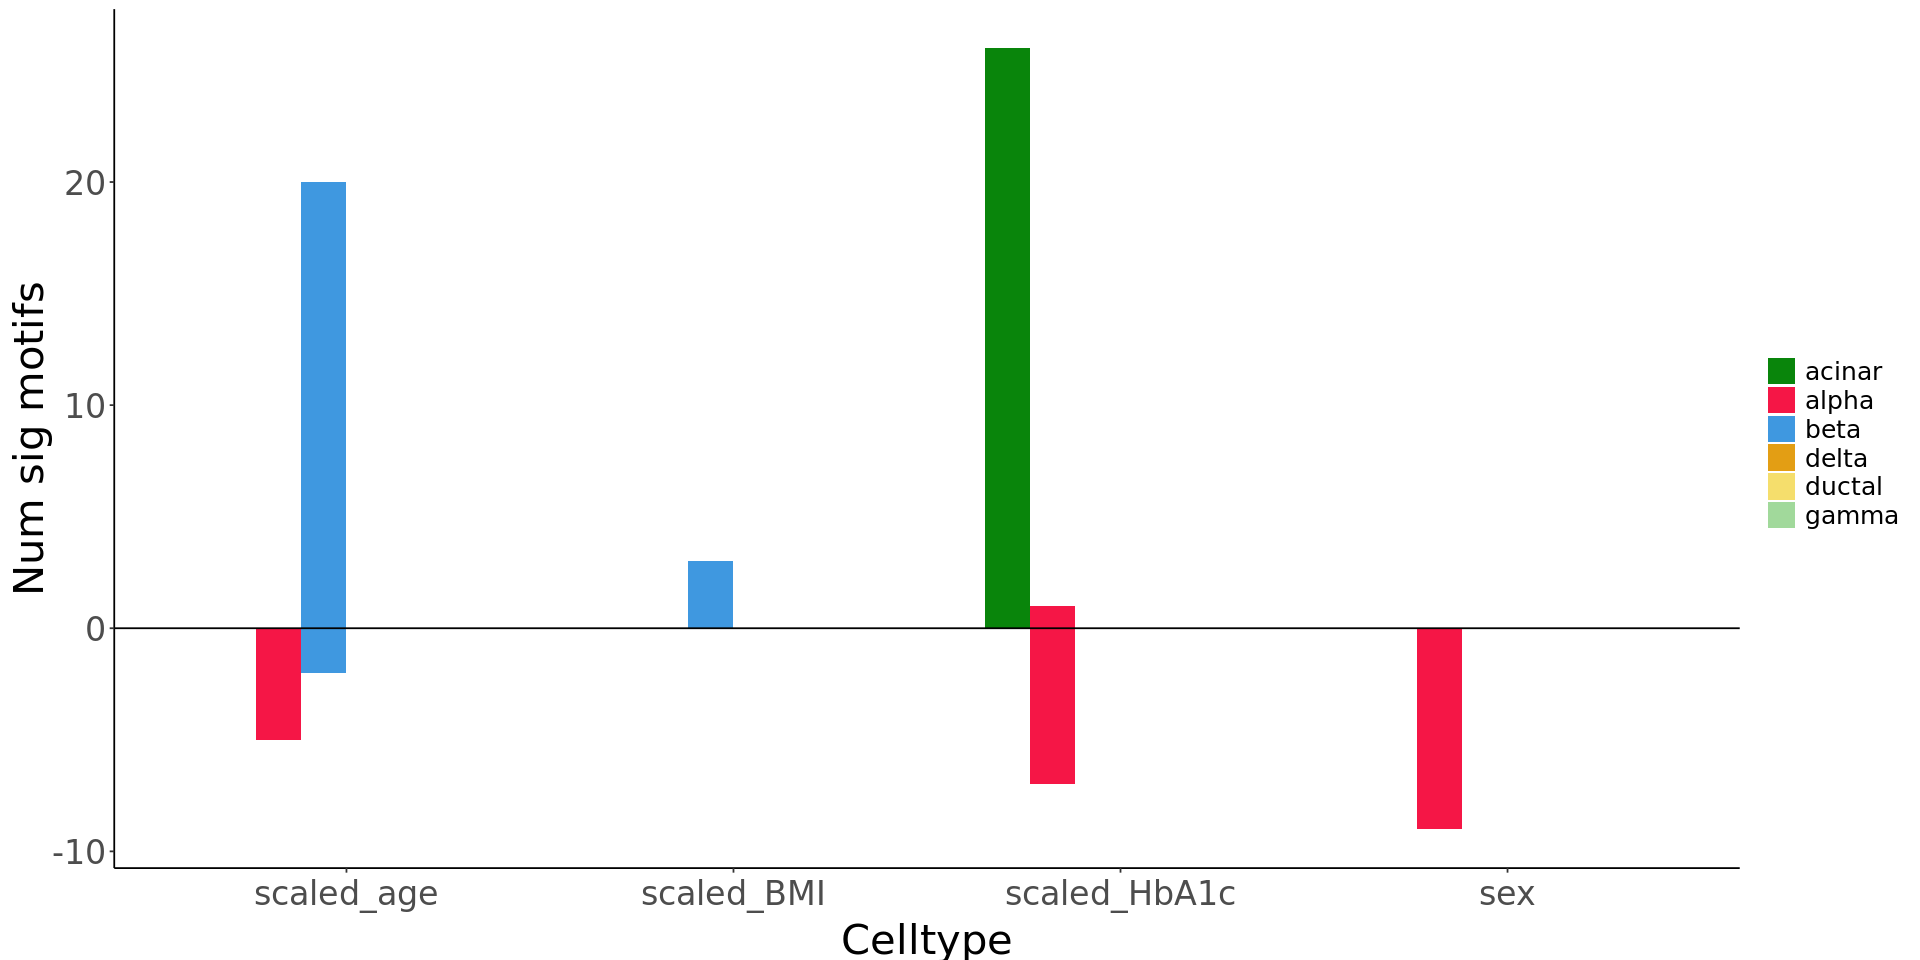

In [42]:
summarize_HOMER_sig_motifs(traits, joint_celltypes, homer_dir, colors)

In [43]:
### visualizze the top sig different motifs per celltype-trait association

celltype <- 'beta'
trait <- 'scaled_age'
dir <- 'up'

fp <- file.path(homer_dir,'sig_motifs',sprintf('%s_%s_%s.HOMER_sig_motifs.bed', celltype, trait, dir))
df <- read.table(fp, sep='\t', header=1)
df

motif,pval,neglog10p,padj,perc_target_seq_w_motif,perc_bg_seq_w_motif,fc,l2fc
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NFIL3,1e-07,7,0.0000220000,14.83,6.91,1.1461650,0.19681472
Six2,1e-07,7,0.0000220000,16.27,8.33,0.9531813,-0.06917749
Six4,1e-06,6,0.0001466667,3.35,0.57,4.8771930,2.28605106
WT1,1e-05,5,0.0008800000,15.07,8.46,0.7813239,-0.35600739
Six1,1e-05,5,0.0008800000,6.70,2.61,1.5670498,0.64805104
HLF,1e-04,4,0.0044000000,13.16,7.27,0.8101788,-0.30368773
Mef2d,1e-04,4,0.0044000000,5.02,1.84,1.7282609,0.78932100
Mef2b,1e-04,4,0.0044000000,11.48,6.31,0.8193344,-0.28747572
Egr2,1e-04,4,0.0044000000,6.22,2.64,1.3560606,0.43942166


In [44]:
### visualizze the top sig different motifs per celltype-trait association

celltype <- 'alpha'
trait <- 'scaled_age'
dir <- 'down'

fp <- file.path(homer_dir,'sig_motifs',sprintf('%s_%s_%s.HOMER_sig_motifs.bed', celltype, trait, dir))
df <- read.table(fp, sep='\t', header=1)
df

motif,pval,neglog10p,padj,perc_target_seq_w_motif,perc_bg_seq_w_motif,fc,l2fc
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NFY,1e-05,5,0.0044,72.73,12.61,4.767645,2.253277
Brn1,1e-03,3,0.0880,36.36,2.75,12.221818,3.611387
Oct11,1e-03,3,0.0880,36.36,3.00,11.120000,3.475085
Oct6,1e-03,3,0.0880,36.36,3.60,9.100000,3.185867
Oct4,1e-03,3,0.0880,36.36,4.15,7.761446,2.956325


In [45]:
### visualizze the top sig different motifs per celltype-trait association

celltype <- 'acinar'
trait <- 'scaled_HbA1c'
dir <- 'up'

fp <- file.path(homer_dir,'sig_motifs',sprintf('%s_%s_%s.HOMER_sig_motifs.bed', celltype, trait, dir))
df <- read.table(fp, sep='\t', header=1)
df

motif,pval,neglog10p,padj,perc_target_seq_w_motif,perc_bg_seq_w_motif,fc,l2fc
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ELF3,1e-12,12,4.400000e-10,50.00,14.41,2.469813,1.30440160
EHF,1e-10,10,2.200000e-08,56.76,21.80,1.603670,0.68137705
ELF5,1e-08,8,1.100000e-06,41.89,13.60,2.080147,1.05668553
NFkB-p65-Rel,1e-08,8,1.100000e-06,17.57,1.98,7.873737,2.97704859
ETV1,1e-07,7,5.500000e-06,48.65,20.20,1.408416,0.49407336
NFkB-p65,1e-07,7,5.500000e-06,31.08,8.90,2.492135,1.31738212
Elf4,1e-07,7,5.500000e-06,43.24,16.83,1.569222,0.65004912
PU.1,1e-07,7,5.500000e-06,29.73,8.33,2.569028,1.36122240
Etv2,1e-06,6,4.000000e-05,40.54,15.70,1.582166,0.66190061


# 3. GWAS Enrichment with FINRICH

Install finrich: `pip3 install finrich` (https://pypi.org/project/finrich/)

Rebecca's Script: `/nfs/lab/rlmelton/npod/notebooks/sherlock/Downstream_analysis_nPOD_april2022/Publication/Final_Downstream/Finrich/20220920_allCelltypes_Finrich.sh`

Example FINRICH call from her script
```
cd /nfs/lab/rlmelton/npod/notebooks/sherlock/Downstream_analysis_nPOD_april2022/HumanGenetics/20220920_${cell}/

T1Dfinemap="/nfs/lab/T1D_Nov21/T1D_meta.compiled_credsets.hg38.bed"
testing_signal="20220920_${cell}_${motif}_signal.txt"
background_signal="20220920_${cell}_${motif}_background.txt"

finrich ${T1Dfinemap} ${testing_signal} ${background_signal}  --permutations 1000 --processes 2 > out.txt

#also need overall outputs file to concatenate everything into
awk -v motif=${motif}  'NR == 1 {print motif "|" $0;}' out.txt > ${output_file}
rm out.txt

```

FINRICH inputs:
- finemapped variants bed file
- background.txt (bed file of peaks, tab separated, 3 cols)
- signal.txt (bed file of peaks, tab separated, 3 cols)

In [83]:
#overall this also uses input files we're already made! so I'll just write some code to make the commands similar to the HOMER code above ^

In [13]:
### Function to run FINRICH on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
run_FINRICH <- function(finemap_bed, celltype, trait, dir, great_dir, finrich_dir){
    #create overall output file
    overall_out_fp <- file.path(finrich_dir,'combined_results.txt')
    
    #check if there are enough sig results for the association in the great_dir
    bed_fp <- file.path(great_dir, 'sig_assoc_peaks', trait, sprintf('%s_%s_sig_peaks_%s.bed', celltype, trait, dir))
    
    if(file.exists(bed_fp)){
        #set up finrich code
        bg_fp <- file.path(great_dir, 'ct_peaks', sprintf('%s_union_peaks.bed',celltype))        
        temp_fp <- file.path(finrich_dir, 'temp.txt')
        cmd <- sprintf('finrich %s %s %s --permutations 1000 --processes 2 > %s', finemap_bed, bed_fp, bg_fp, temp_fp)
        system(cmd)

        #concat and reformat outputs slightly
        prefix <- paste(trait, celltype, dir, sep='_')
        out_fp <- file.path(finrich_dir, 'combined_results.txt')
        cmd2 <- sprintf('awk -v prefix=%s \'NR == 1 {print prefix "|" $0;}\' %s >> %s', prefix, temp_fp, out_fp)
        system(cmd2)
        system(sprintf('rm %s',temp_fp))
    }
}

In [14]:
#collect hg38 finemapping bed files (T1D and T2D)
t1d_old <- "/nfs/lab/T1D_Nov21/T1D_meta.compiled_credsets.hg38.bed"
#t1d_new <- "" #don't use new fine mapping yet
t2d <- "/nfs/lab/relgamal/T1D_T2D_GWAS/DIAMANTE_T2D.credset.hg38.bed"

In [17]:
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
great_dir <- file.path(outdir,'ATAC/GREAT')
finrich_dir1 <- file.path(outdir, 'ATAC', 'FINRICH', 'T1D')

for(celltype in joint_celltypes){
    for(trait in traits){
        for(dir in c('up','down')){
            run_FINRICH(t1d_old, celltype, trait, dir, great_dir, finrich_dir1)
        }
    }
}

In [18]:
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
finrich_dir2 <- file.path(outdir, 'ATAC', 'FINRICH', 'T2D')

for(celltype in joint_celltypes){
    for(trait in traits){
        for(dir in c('up','down')){
            run_FINRICH(t2d, celltype, trait, dir, great_dir, finrich_dir2)
        }
    }
}

## Read in results and see if anything is significant

In [ ]:
#tbh not really sure how to do this... also nothing is sig so whatever

## Also check for general overlap between cREs and cred sets -- probably should do this before running FINRICH in the future!

In [32]:
### Function to run FINRICH on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
check_overlap <- function(finemap_bed, celltype, trait, dir, great_dir, log_fp){
    #check if there are enough sig results for the association in the great_dir
    bed_fp <- file.path(great_dir, 'sig_assoc_peaks', trait, sprintf('%s_%s_sig_peaks_%s.bed', celltype, trait, dir))
    
    if(file.exists(bed_fp)){
        system(sprintf('echo %s >> %s',paste(celltype, trait, dir, sep="_"),log_fp))
        bg_fp <- file.path(great_dir, 'ct_peaks', sprintf('%s_union_peaks.bed',celltype))
        cmd <- sprintf('bedtools intersect -a %s -b %s -wa -wb | wc -l >> %s', bg_fp, finemap_bed, log_fp)
        cmd2 <- sprintf('bedtools intersect -a %s -b %s -wa -wb | wc -l >> %s', bed_fp, finemap_bed, log_fp)
        system(cmd)
        system(cmd2)
    }
}

In [34]:
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
great_dir <- file.path(outdir,'ATAC/GREAT')
log_fp <- file.path(outdir, 'ATAC', 'FINRICH','T1D_overlap_log.txt')

for(celltype in joint_celltypes){
    for(trait in traits){
        for(dir in c('up','down')){
            check_overlap(t1d_old, celltype, trait, dir, great_dir, log_fp)
        }
    }
}

In [35]:
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
finrich_dir2 <- file.path(outdir, 'ATAC', 'FINRICH', 'T2D')
log_fp <- file.path(outdir, 'ATAC', 'FINRICH','T2D_overlap_log.txt')

for(celltype in joint_celltypes){
    for(trait in traits){
        for(dir in c('up','down')){
            check_overlap(t2d, celltype, trait, dir, great_dir, log_fp)
        }
    }
}

# 4. Check if linked genes have concordant phenotype changes

# Make pathways out of linked genes and run fGSEA on the trait association results

In [9]:
fgsea_outdir <- file.path(outdir,'ATAC','linked_gene_fGSEA')
gmt_dir <- file.path(fgsea_outdir,'gmt_files')

## Create gmt file with linked genes

In [11]:
### Function to extract all cREs nominally linked to a trait in a celltype (and in certain direction!)
get_nominal_cres <- function(celltype, trait, dir, p_cutoff=0.01){
    fp <- file.path(deseq_outdir,trait,sprintf('ATAC_deseq_v4.%s.%s.tsv',trait, celltype))
    df <- read.table(fp, sep='\t', header=1)
    if (dir=='up') df_sig_dir <- subset(df, pvalue<p_cutoff & log2FoldChange > 0)
    if (dir=='down') df_sig_dir <- subset(df, pvalue<p_cutoff & log2FoldChange < 0)    
    sig_peaks <- row.names(df_sig_dir)
    sig_df <- as.data.frame(str_split_fixed(sig_peaks,'-',3))
    sig_df$V4 <- sig_peaks
    return(sig_df)
}

In [12]:
### Function to get the list of all genes linked to 1/+ peaks in a list
### Note: peaks are union peaks, so use those links files (also format: chr-start-end)
get_linked_genes <- function(celltype, cres, method_strs){
    fp <- file.path(links_dir, sprintf('%s_all_methods_links.wHeader.wUnionPeaks.bedpe',celltype))
    df <- read.table(fp, sep='\t', header=1)
    df$cre <- paste(df$chr, df$start, df$end, sep='-')
    genes <- subset(df, cre %in% cres & method_str %in% method_strs) %>% pull(gene)
    return(genes)
}

In [16]:
dfs <- list()

for(celltype in joint_celltypes){
    for(trait in traits){
        up_cres <- get_nominal_cres(celltype, trait, 'up')
        down_cres <- get_nominal_cres(celltype, trait, 'down')
        up_genes <- get_linked_genes(celltype, sort(unique(up_cres$V4)), link_methods)
        down_genes <- get_linked_genes(celltype, sort(unique(down_cres$V4)), link_methods)

        df1 <- data.frame(id=paste(celltype,trait,'up',sep='-'), name=paste(celltype,trait,'up',sep='-'), gene=up_genes)
        df2 <- data.frame(id=paste(celltype,trait,'down',sep='-'), name=paste(celltype,trait,'down',sep='-'), gene=down_genes)
        gmt_df <- rbind(df1,df2)
        dfs[[paste(celltype,trait,sep='-')]] <- gmt_df
    }
}

In [17]:
lapply(dfs, dim)

$`beta-scaled_age`
[1] 5889    3

$`beta-scaled_BMI`
[1] 4833    3

$`beta-scaled_HbA1c`
[1] 3436    3

$`beta-sex`
[1] 2902    3

$`alpha-scaled_age`
[1] 1614    3

$`alpha-scaled_BMI`
[1] 2786    3

$`alpha-scaled_HbA1c`
[1] 5823    3

$`alpha-sex`
[1] 6721    3

$`delta-scaled_age`
[1] 1256    3

$`delta-scaled_BMI`
[1] 1972    3

$`delta-scaled_HbA1c`
[1] 2639    3

$`delta-sex`
[1] 1914    3

$`gamma-scaled_age`
[1] 1273    3

$`gamma-scaled_BMI`
[1] 1831    3

$`gamma-scaled_HbA1c`
[1] 2057    3

$`gamma-sex`
[1] 2387    3

$`acinar-scaled_age`
[1] 1466    3

$`acinar-scaled_BMI`
[1] 2652    3

$`acinar-scaled_HbA1c`
[1] 3055    3

$`acinar-sex`
[1] 2623    3

$`ductal-scaled_age`
[1] 1506    3

$`ductal-scaled_BMI`
[1] 3223    3

$`ductal-scaled_HbA1c`
[1] 2124    3

$`ductal-sex`
[1] 2356    3

In [18]:
fin_gmt <- as.data.frame(rbindlist(dfs))
dim(fin_gmt)
head(fin_gmt)

[1] 68338     3

,id,name,gene
,<chr>,<chr>,<chr>
1,beta-scaled_age-up,beta-scaled_age-up,ATAD3A
2,beta-scaled_age-up,beta-scaled_age-up,PLCH2
3,beta-scaled_age-up,beta-scaled_age-up,PANK4
4,beta-scaled_age-up,beta-scaled_age-up,PLCH2
5,beta-scaled_age-up,beta-scaled_age-up,SKI
6,beta-scaled_age-up,beta-scaled_age-up,PRDM16


In [26]:
out_fp <- file.path(gmt_dir, 'all_cts_trait_assoc_nom_peak_linked_genes.gmt')
writeGMT(fin_gmt, out_fp)

## Run fGSEA using linked genes pathways

In [27]:
### Function to run fGSEA and write outputs to a file
run_fGSEA_on_REM <- function(celltype, trait, pathways, pathways_name, outdir, only_auto=FALSE){
    #read in REM results and calculate rank?
    fp <- file.path(rna_deseq_outdir, trait, sprintf('%s_%s.all_genes_REM_results.txt', celltype, trait))
    df <- read.table(fp, sep='\t', header=1)
    
    # If only_auto==TRUE, remove any genes on sex chromosomes
    if(only_auto==TRUE){
        ref_df <- read.table('/nfs/lab/ABC/references/gene_coords.gencodev32.hg38.bed', sep='\t', header=FALSE)
        auto_genes <- subset(ref_df, !grepl('X|Y',V1)) %>% pull(V4)
        df_fin <- df[row.names(df) %in% auto_genes,]
    } else{
        df_fin <- df
    }
    rank <- -log10(df_fin$pvalue) * df_fin$effect
    names(rank) <- rownames(df_fin)

    #Run fGSEA
    res <- fgsea(pathways = pathways, 
                 stats    = rank,
                 eps      = 0.0,
                 minSize  = 0,
                 maxSize  = Inf)

    # Output results to a file (sorted by padj)
    out_fp <- file.path(outdir, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
    fwrite(res[order(res$padj),], file=out_fp, sep="\t", sep2=c("", " ", ""))
}

In [28]:
rna_celltypes <- c('beta','alpha','delta','acinar','ductal','immune','stellate')

In [29]:
rna_deseq_outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/RNA/REM_meta'

In [30]:
# pathway_fps <- list.files(gmt_dir, full.names = TRUE)
# names(pathway_fps) <- c('all_cts_no_cic','all_cts_overlap','all_cts')
# pathway_fps

In [31]:
# for(name in names(pathway_fps)){
#     pathways <- gmtPathways(pathway_fps[[name]])
    
#     for(trait in traits){
#         trait_outdir <- file.path(fgsea_outdir, trait)
#         dir.create(trait_outdir, showWarnings=FALSE)
        
#         for(celltype in rna_celltypes){
#             run_fGSEA_on_REM(celltype, trait, pathways, name, trait_outdir, FALSE)
#         }
#     }
# }

In [35]:
pathway_fp <- file.path(gmt_dir, 'all_cts_trait_assoc_nom_peak_linked_genes.gmt')
pathways <- gmtPathways(pathway_fp)
name <- 'all_cts'

#run fgsea with pathways
for(trait in traits){
    trait_outdir <- file.path(fgsea_outdir, trait)
    dir.create(trait_outdir, showWarnings=FALSE)
    
    for(celltype in rna_celltypes){
        run_fGSEA_on_REM(celltype, trait, pathways, name, trait_outdir, FALSE)
    }
}

Warning message in fgseaMultilevel(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”


## Visualize fGSEA results

In [36]:
### summarize sig genes results (plot with up and down as + and -)
summarize_fGSEA_pathways <- function(traits, celltypes, pathways_str, fgsea_outdir, colors, padj_cutoff=0.1){
    #collect up and down info separately
    summary_df_up <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_str))
            df <- fread(fp)
            num_sig <- c(num_sig, dim(df[df$padj < padj_cutoff & df$ES > 0,])[1])
        }
        summary_df_up <- rbind(summary_df_up, num_sig)
    }
    colnames(summary_df_up) <- traits

    summary_df_down <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_str))
            df <- fread(fp)
            num_sig <- c(num_sig, dim(df[df$padj_cutoff < padj_cutoff & df$ES < 0,])[1])
        }
        summary_df_down <- rbind(summary_df_down, num_sig)
    }
    colnames(summary_df_down) <- traits

    #merge up/down dfs into one dataframe
    summary_df_up$celltype <- celltypes
    summary_df_down <- -summary_df_down
    summary_df_down$celltype <- celltypes
    data <- rbind(melt(summary_df_up, id.vars='celltype'), melt(summary_df_down, id.vars='celltype'))
    
    # Make grouped barplot of desired metadata
    options(repr.plot.width=16, repr.plot.height=8)
    theme_set(
        theme_classic())

    p1 <- ggplot(data, aes(fill=celltype, y=value, x=variable)) + 
            geom_bar(position="dodge", stat="identity", width=0.7) + 
            geom_hline(yintercept=0) + 
            labs(x = "Celltype", y='Num sig pathways', color="Cell Type", title=sprintf('fGSEA using %s linked genes gmts',pathways_str)) + 
            scale_fill_manual(values=colors) + 
            theme(axis.text.x=element_text(size=20, vjust=0.5),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=25, vjust=-0.35),
            axis.title.y = element_text(size=25, vjust=0.5),
            legend.title = element_blank(),
            legend.text = element_text(size=15),
            plot.title = element_text(size=25, hjust=0.5, face="bold"))
    print(p1)
}

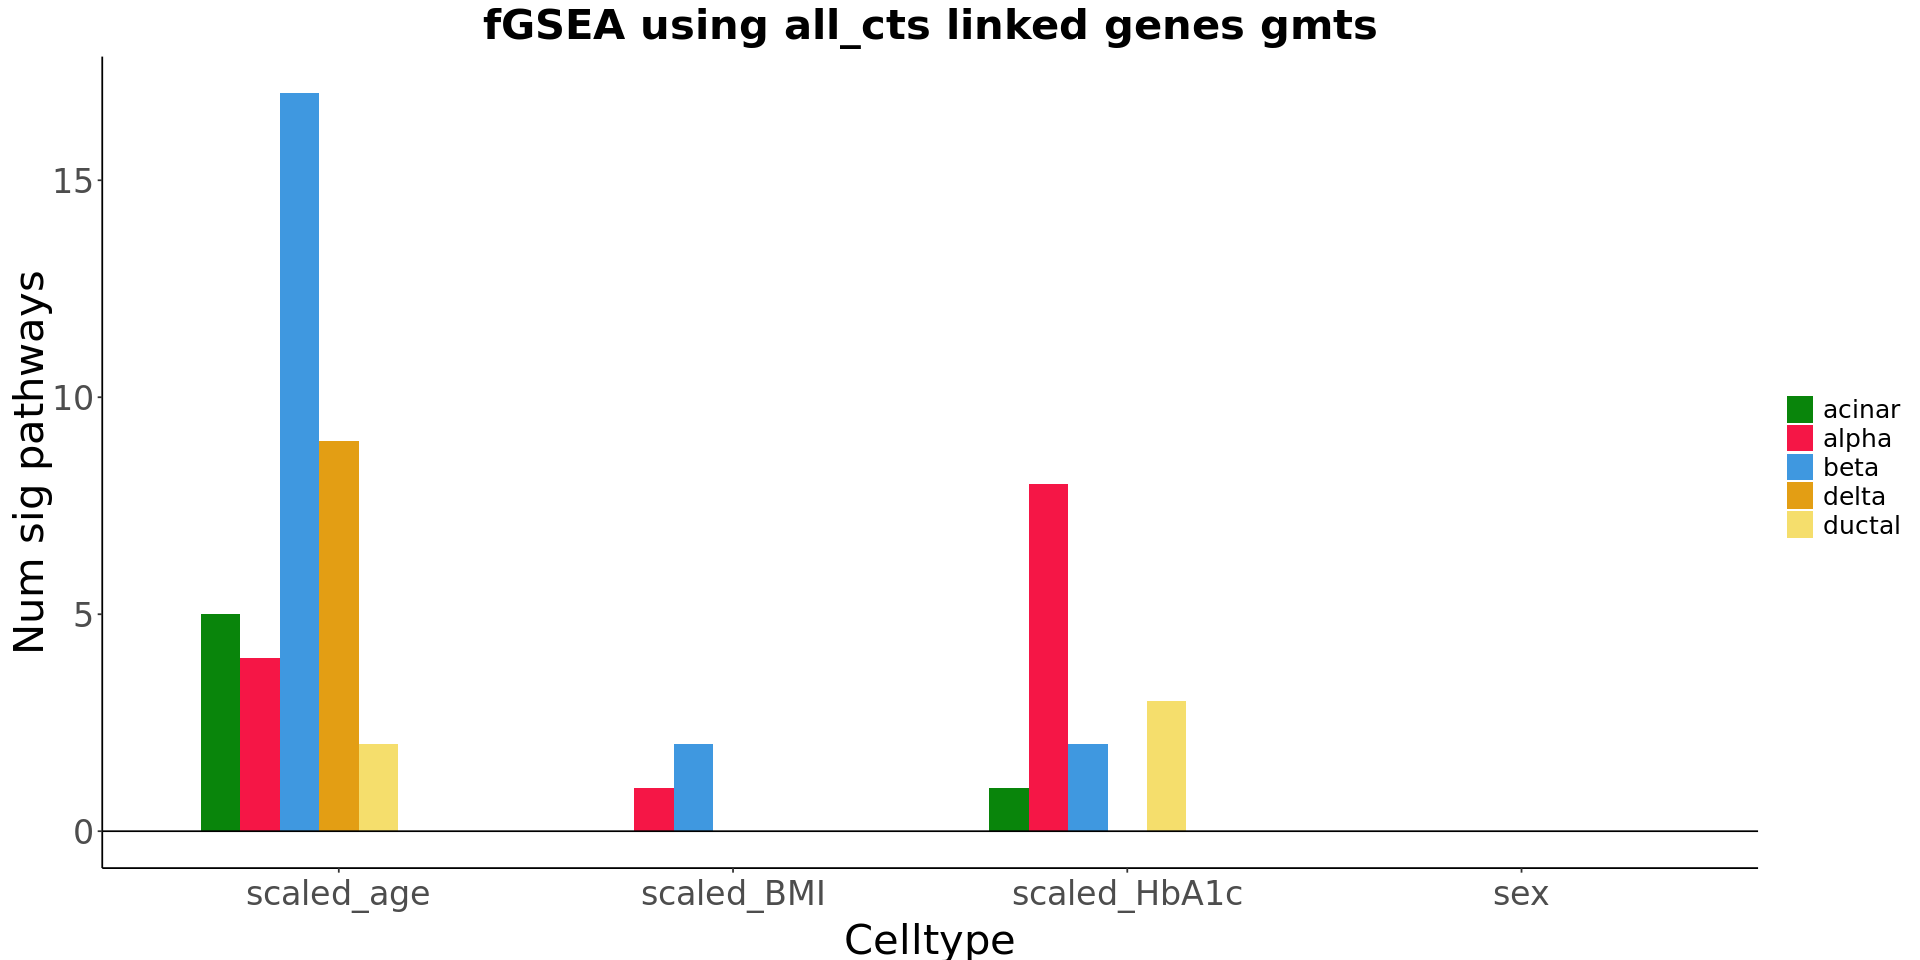

In [38]:
suppressWarnings(summarize_fGSEA_pathways(traits, rna_celltypes, 'all_cts', fgsea_outdir, colors, padj_cutoff=0.1))
# suppressWarnings(summarize_fGSEA_pathways(traits, rna_celltypes, 'all_cts_no_cic', fgsea_outdir, colors, padj_cutoff=0.1))
# suppressWarnings(summarize_fGSEA_pathways(traits, rna_celltypes, 'all_cts_overlap', fgsea_outdir, colors, padj_cutoff=0.1))

In [39]:
#adapting previous plotting function to just make one plot at a time so I can make a composite plot more easily
gsea_one_dir_plt <- function(data, cell, var, color, numpathways, labelthresh, plt_dir){
    plt_title <- sprintf('%s %s-regulated pathways (-log10p)', var, plt_dir)

    #prepare df for plotting
    data$LOG10P <- -log10(data$pval)
    data <- data[order(data$pval),]

    #cut df down to just up/down pathways
    if (plt_dir == 'up'){
        plt_data <- data[which(data$ES > 0),][c(1:numpathways),]        
    } else if (plt_dir == 'down'){
        plt_data <- data[which(data$ES < 0),][c(1:numpathways),]            
    }
    
    #before preceding, make sure there are still things to plot
    #check if still have any pathways after selecting up/down
    plt_data <- na.omit(plt_data)
    make_plot <- ifelse(dim(plt_data)[1] > 0, TRUE, FALSE)
    
    if (make_plot == TRUE){        
        #factor pathways (idk why)
        plt_data$pathway <- factor(plt_data$pathway, levels= plt_data$pathway)
        plt_data$pathway <- fct_rev(plt_data$pathway)

        #make plot 
        plt <- ggplot(plt_data) +
                      geom_col(aes(LOG10P, pathway), fill= color, width = 0.9) + theme_classic() + 
                      scale_x_continuous(limits = c(0, (ceiling(max(plt_data$LOG10P, na.rm = TRUE)) + 0.5)),
                        breaks = seq(0, ceiling(max(plt_data$LOG10P, na.rm = TRUE)), by = 3), 
                        expand = c(0, 0), # The horizontal axis does not extend to either side
                        position = 'top') + # Labels are located on the top
                      scale_y_discrete(expand = expansion(add = c(0, 0.5))) +
                      theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), #change to 0.3 possibly?
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16)) + 
                      geom_shadowtext(
                        data = subset(plt_data, LOG10P >= labelthresh),
                        aes(0, y = pathway, label = pathway),
                        hjust = 0,
                        nudge_x = 0.3,
                        colour = 'white',
                        bg.colour = color,
                        bg.r = 0.2,
                        size = 10) + 
                      geom_text(data = subset(plt_data, LOG10P >= labelthresh),
                        aes(0, y = pathway, label = pathway),
                        hjust = 0,nudge_x = 0.3,colour = 'white',size = 10) +
                      labs(title = '', subtitle = plt_title) +
                      theme(plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))  
        
    #if no data passes sig threshold return blank plot
    } else {
        plt <- ggplot(plt_data) + 
                    geom_blank() + 
                    labs(title = '', subtitle = plt_title) +
                    theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), #change to 0.3 possibly?
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16),
                        plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))
    }
    return(plt)
}

In [40]:
### Short wrapper function for Ruth's plots, reads in res from a fp and then filters for padj threshold
### 7/12/23: adapted to make all plots for each trait for a cell type using new function and ggarrange them
make_ct_pathway_plots <- function(celltype, traits, fgsea_outdir, pathways_name, threshold, colors){
    plot_list <- list()
    
    for (trait in traits){
        # Read in df and filter for significant results
        fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
        df <- read.table(fp, sep='\t', header=TRUE)
        df_sig <- na.omit(df[df$padj < threshold,])

        # Make two cell type colors
        color_up <- colors[[celltype]]
        color_down <- colorRampPalette(colors = c('black',color_up))(4)[3]
        
        #Adjust pathway names (lower case and remove hallmark if applicable)
        df_sig$pathway <- tolower(df_sig$pathway)
        if (pathways_name == 'Hallmark'){
            df_sig$pathway <- gsub('hallmark_','',df_sig$pathway)
        }

        # Call newly adapted version Ruth's function to make up and down plots separately
        plt_down <- gsea_one_dir_plt(df_sig, celltype, trait, color_down, 10, 1, 'down')
        plt_up <- gsea_one_dir_plt(df_sig, celltype, trait, color_up, 10, 1, 'up')
        plot_list[[paste(trait,'down',sep='-')]] <- plt_down
        plot_list[[paste(trait,'up',sep='-')]] <- plt_up
    }
    #make composite plot
    options(repr.plot.width = 30, repr.plot.height=10)
    fig <- ggarrange(plotlist = plot_list, nrow=2, ncol=4)
    fig <- annotate_figure(fig, top=text_grob(sprintf("fGSEA %s pathways for %s cells (DESeq phenotype associations)", pathways_name, celltype),
                           color = 'black', face='bold', size=25))
    print(fig)
}

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


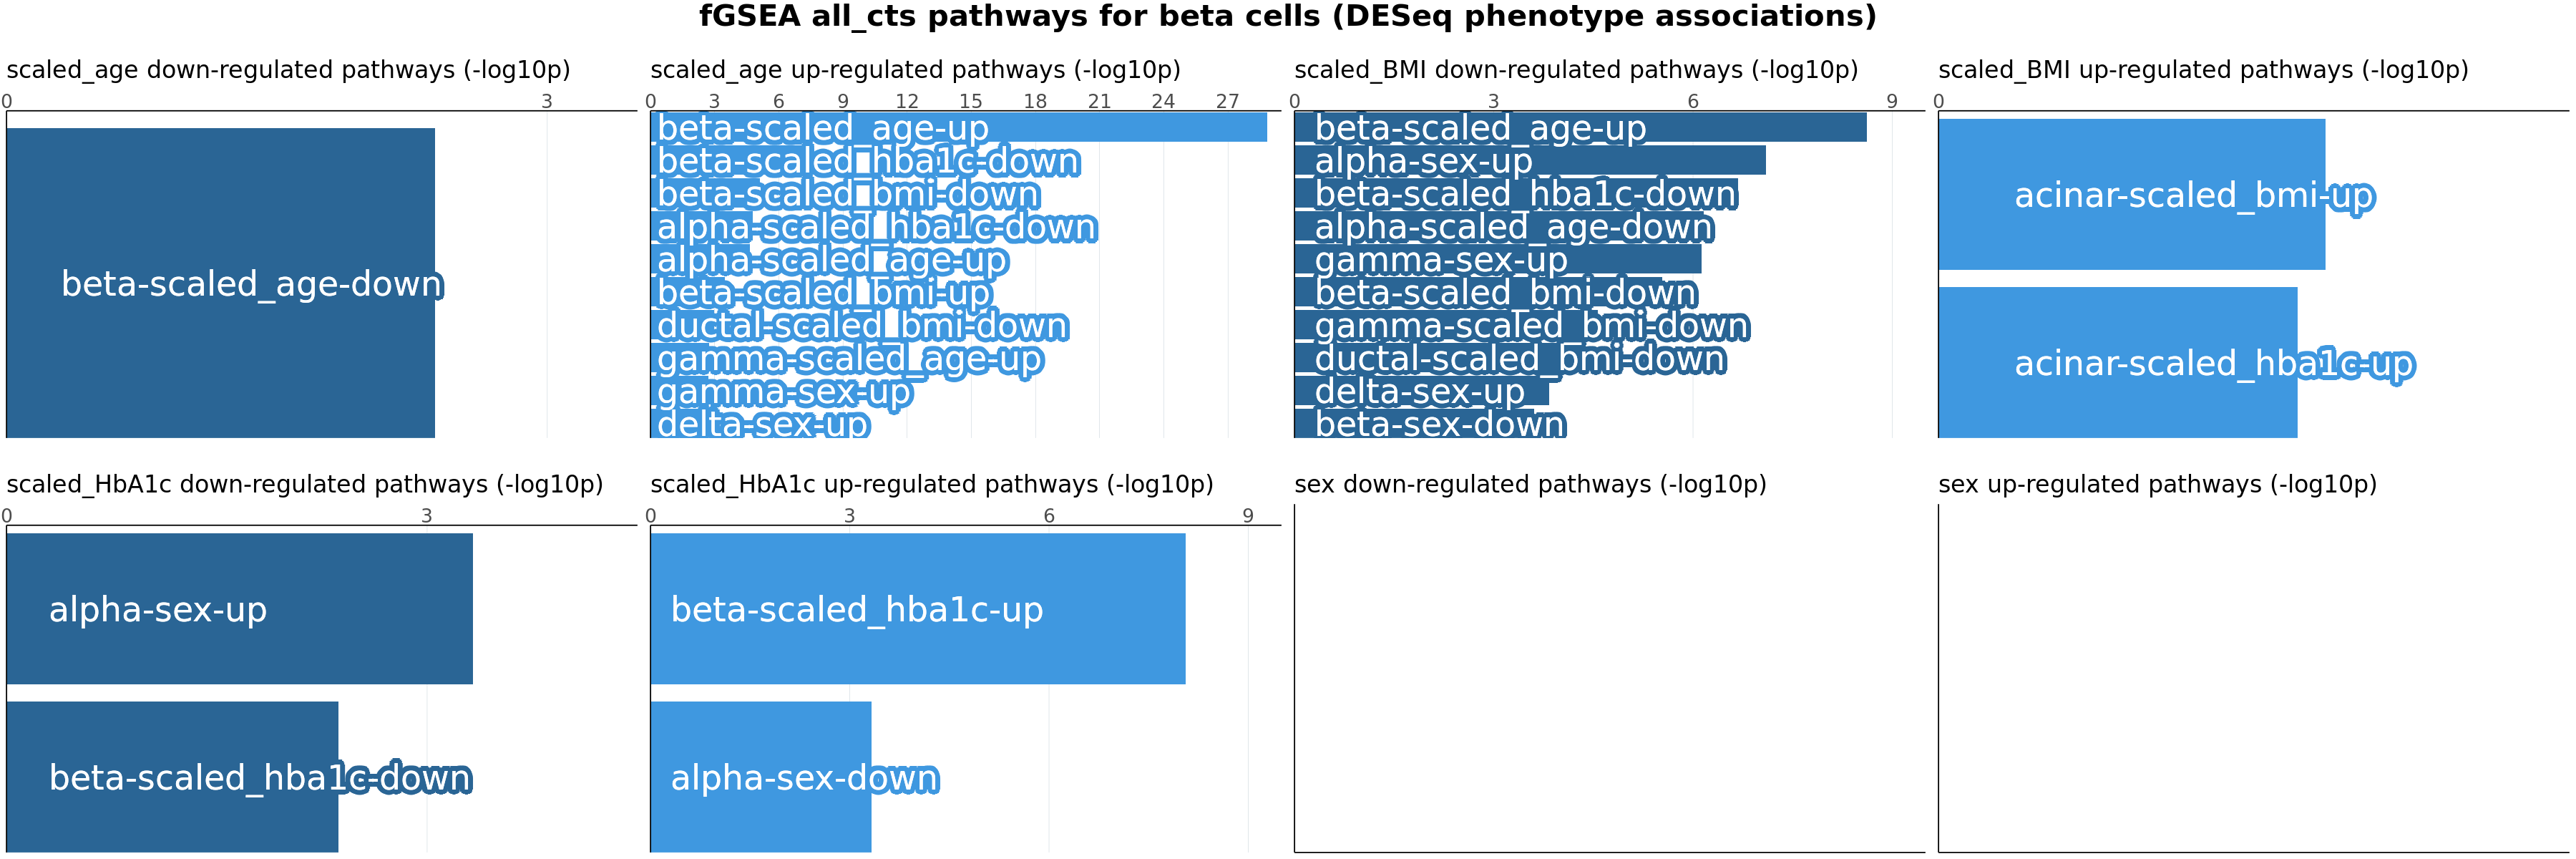

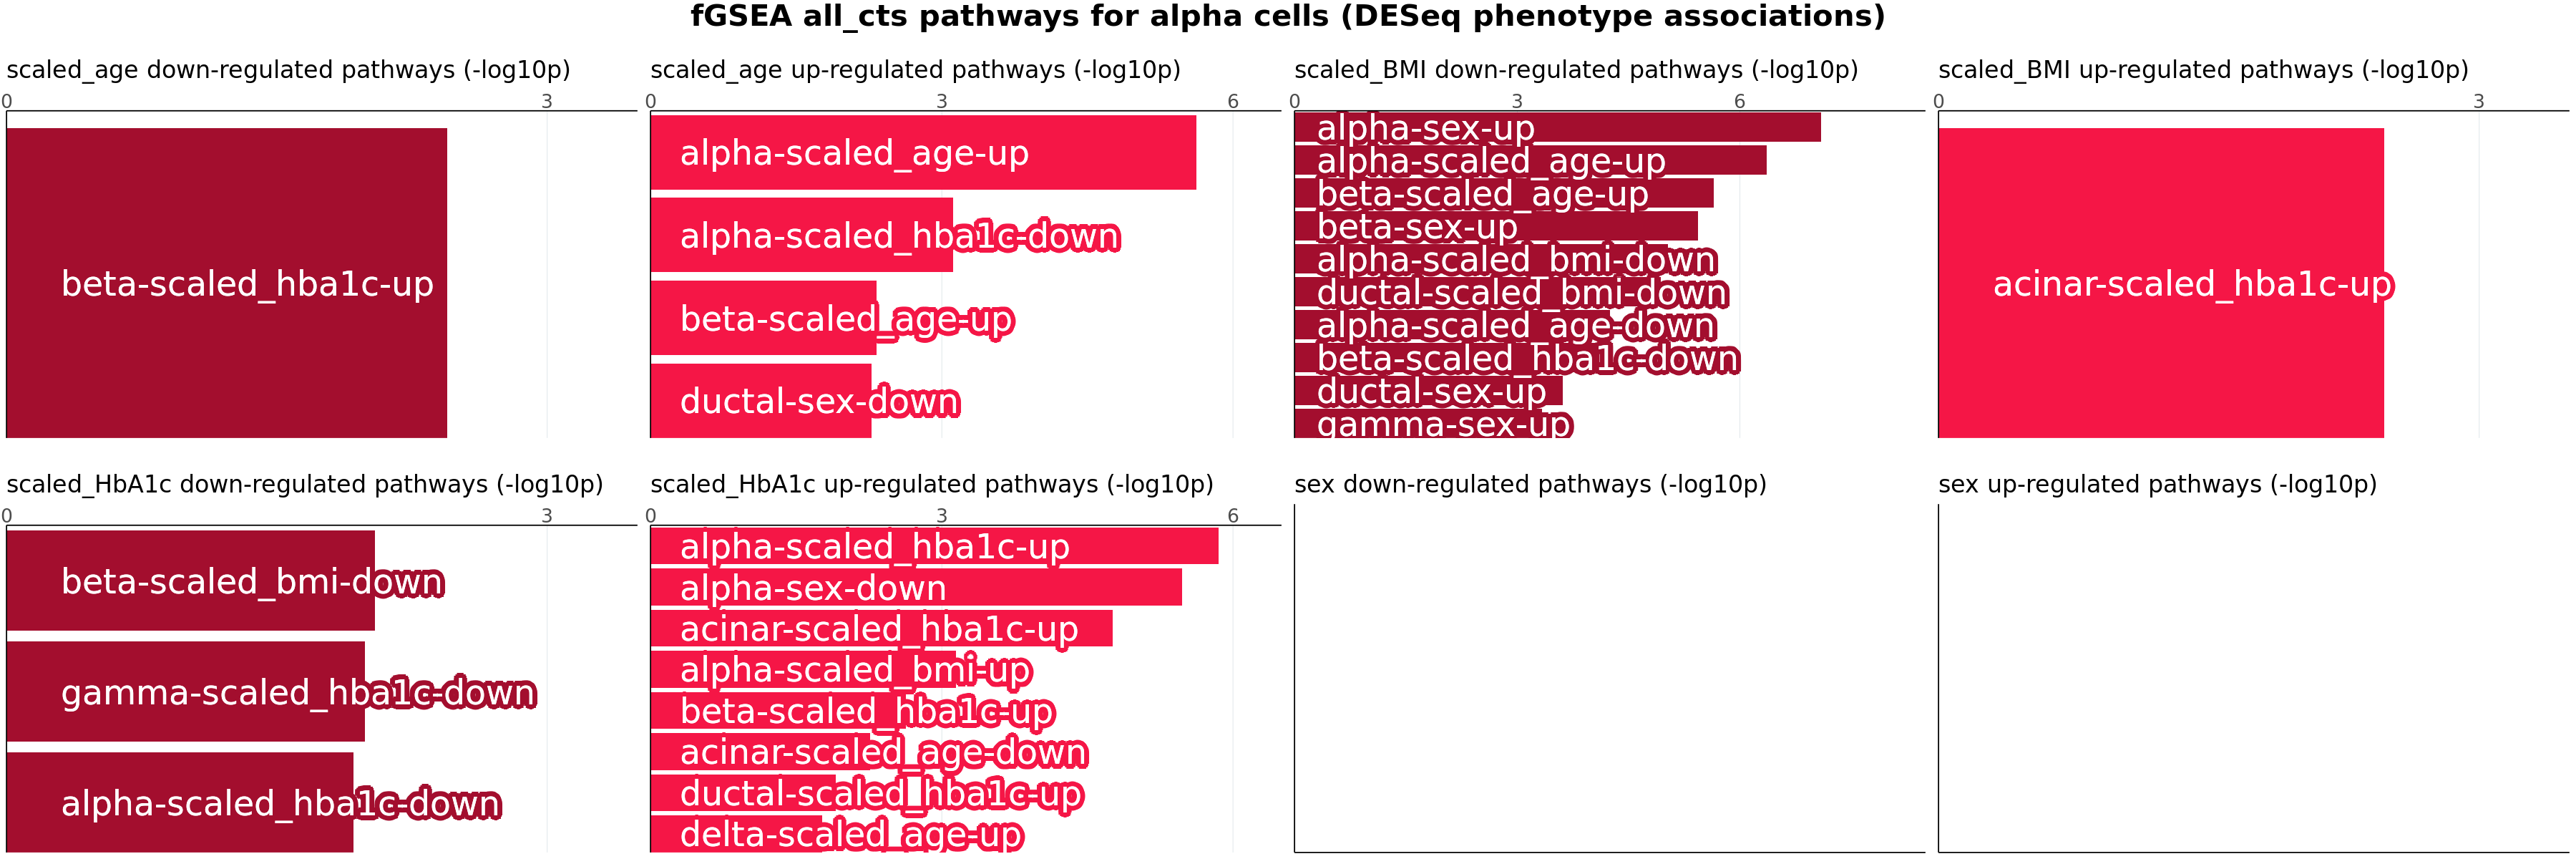

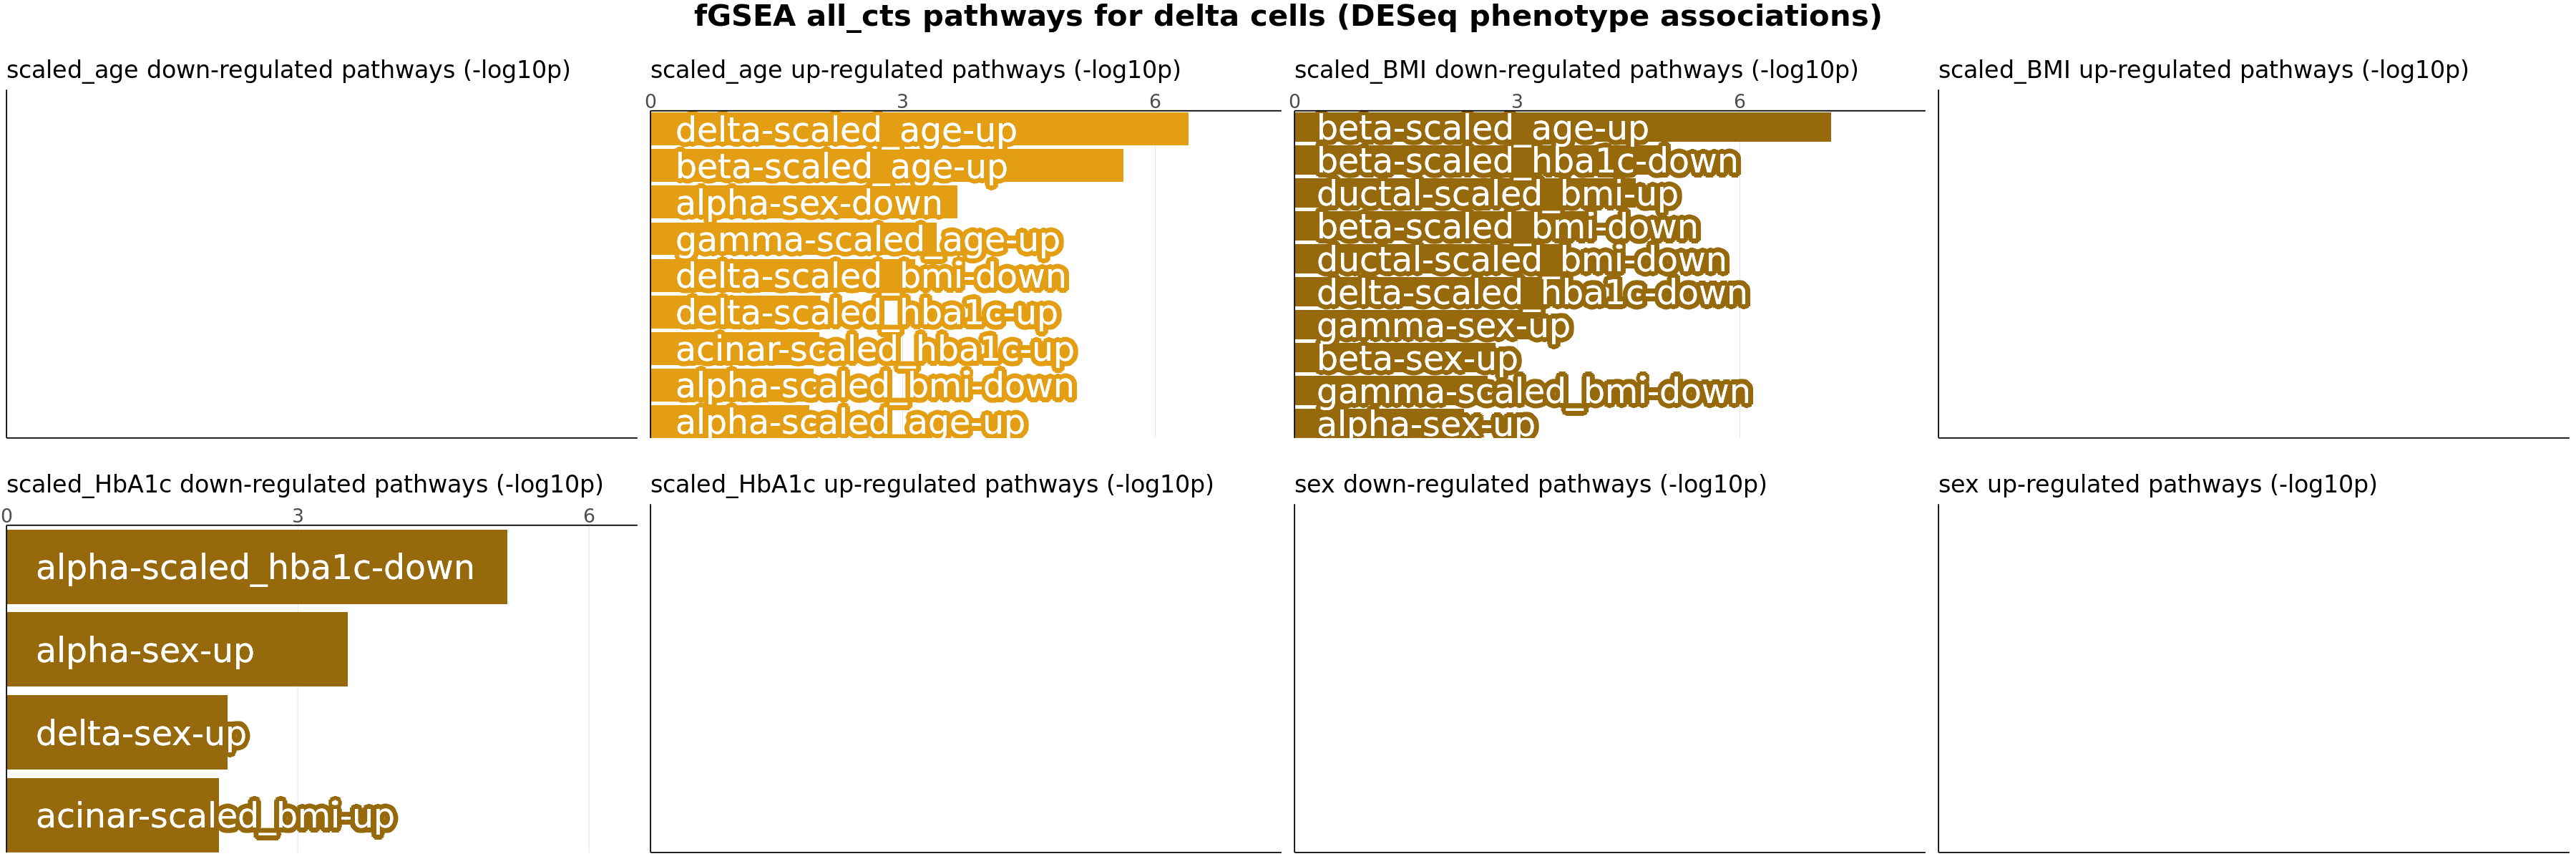

ERROR: Error in colors[[celltype]]: subscript out of bounds


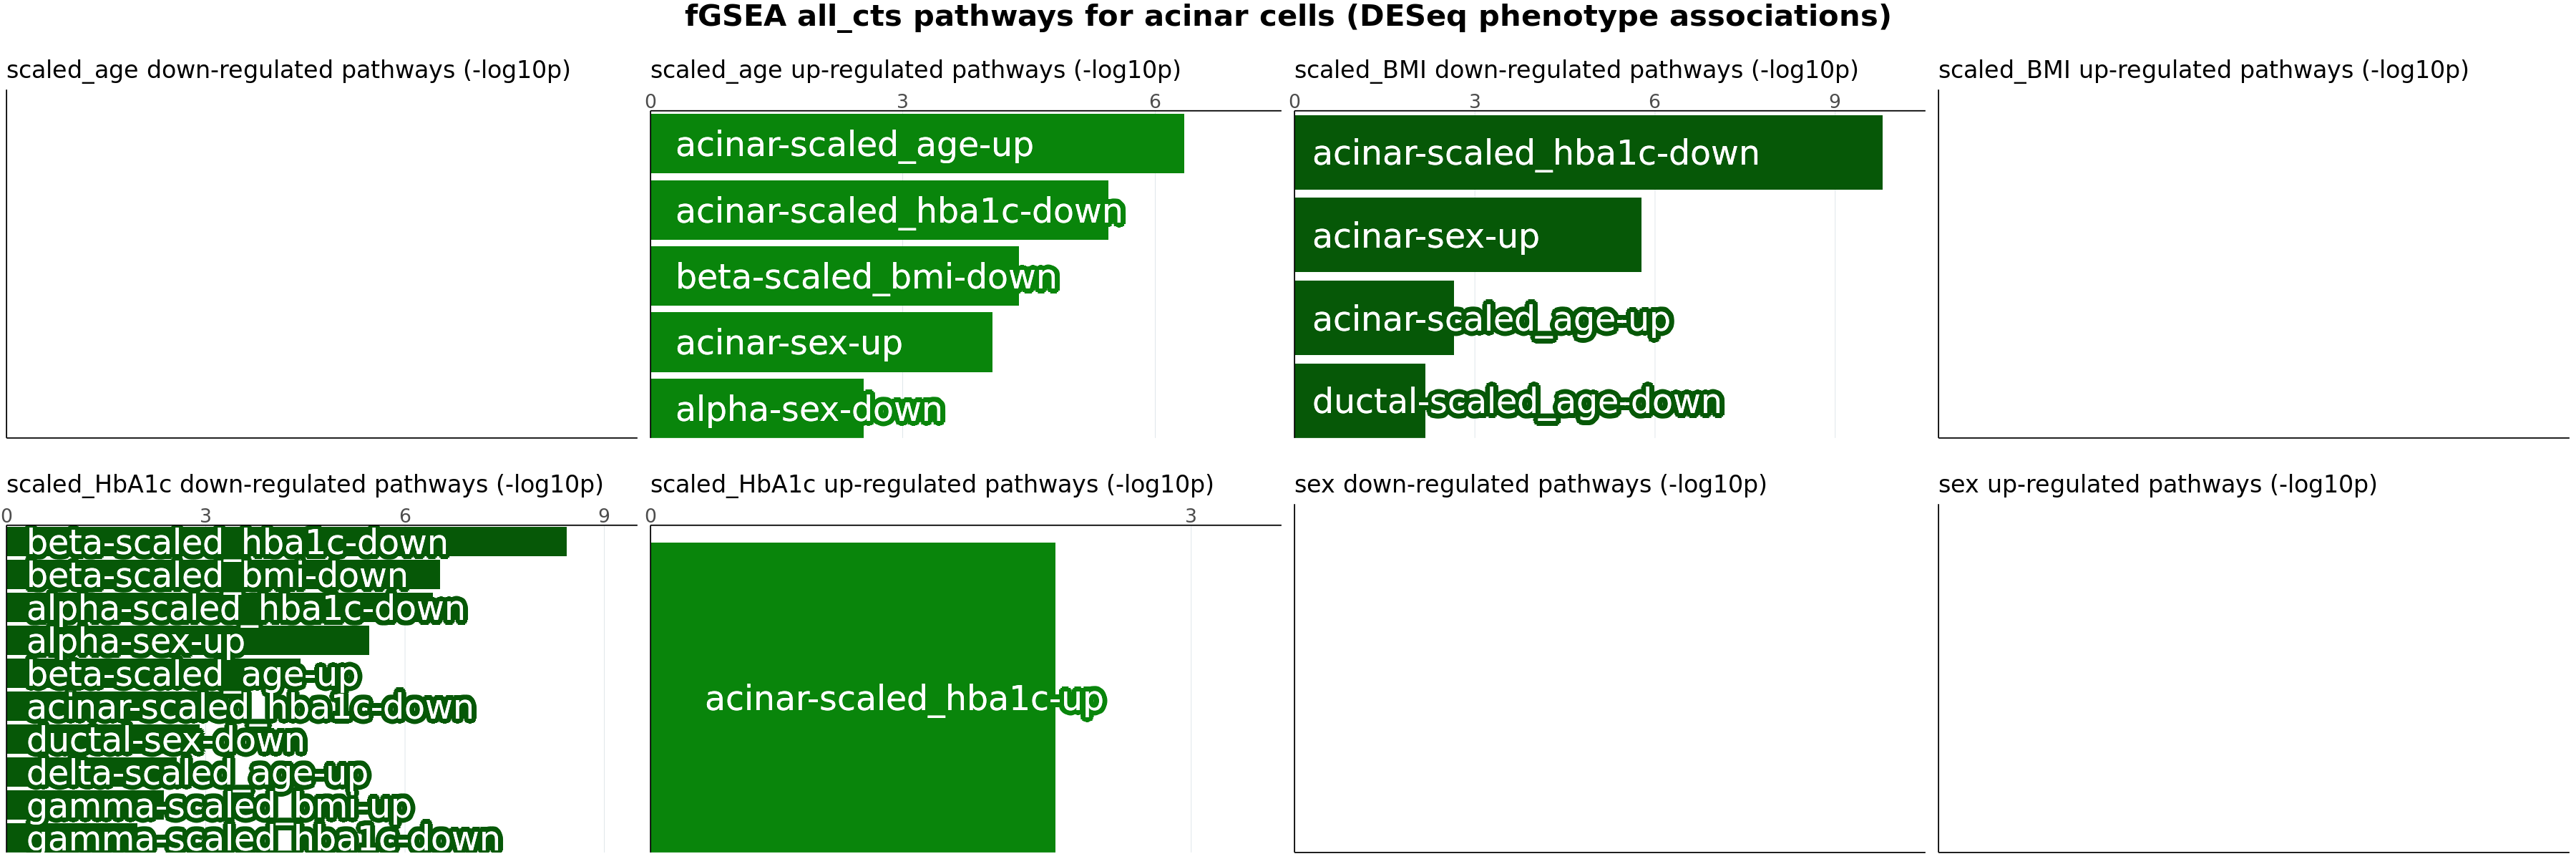

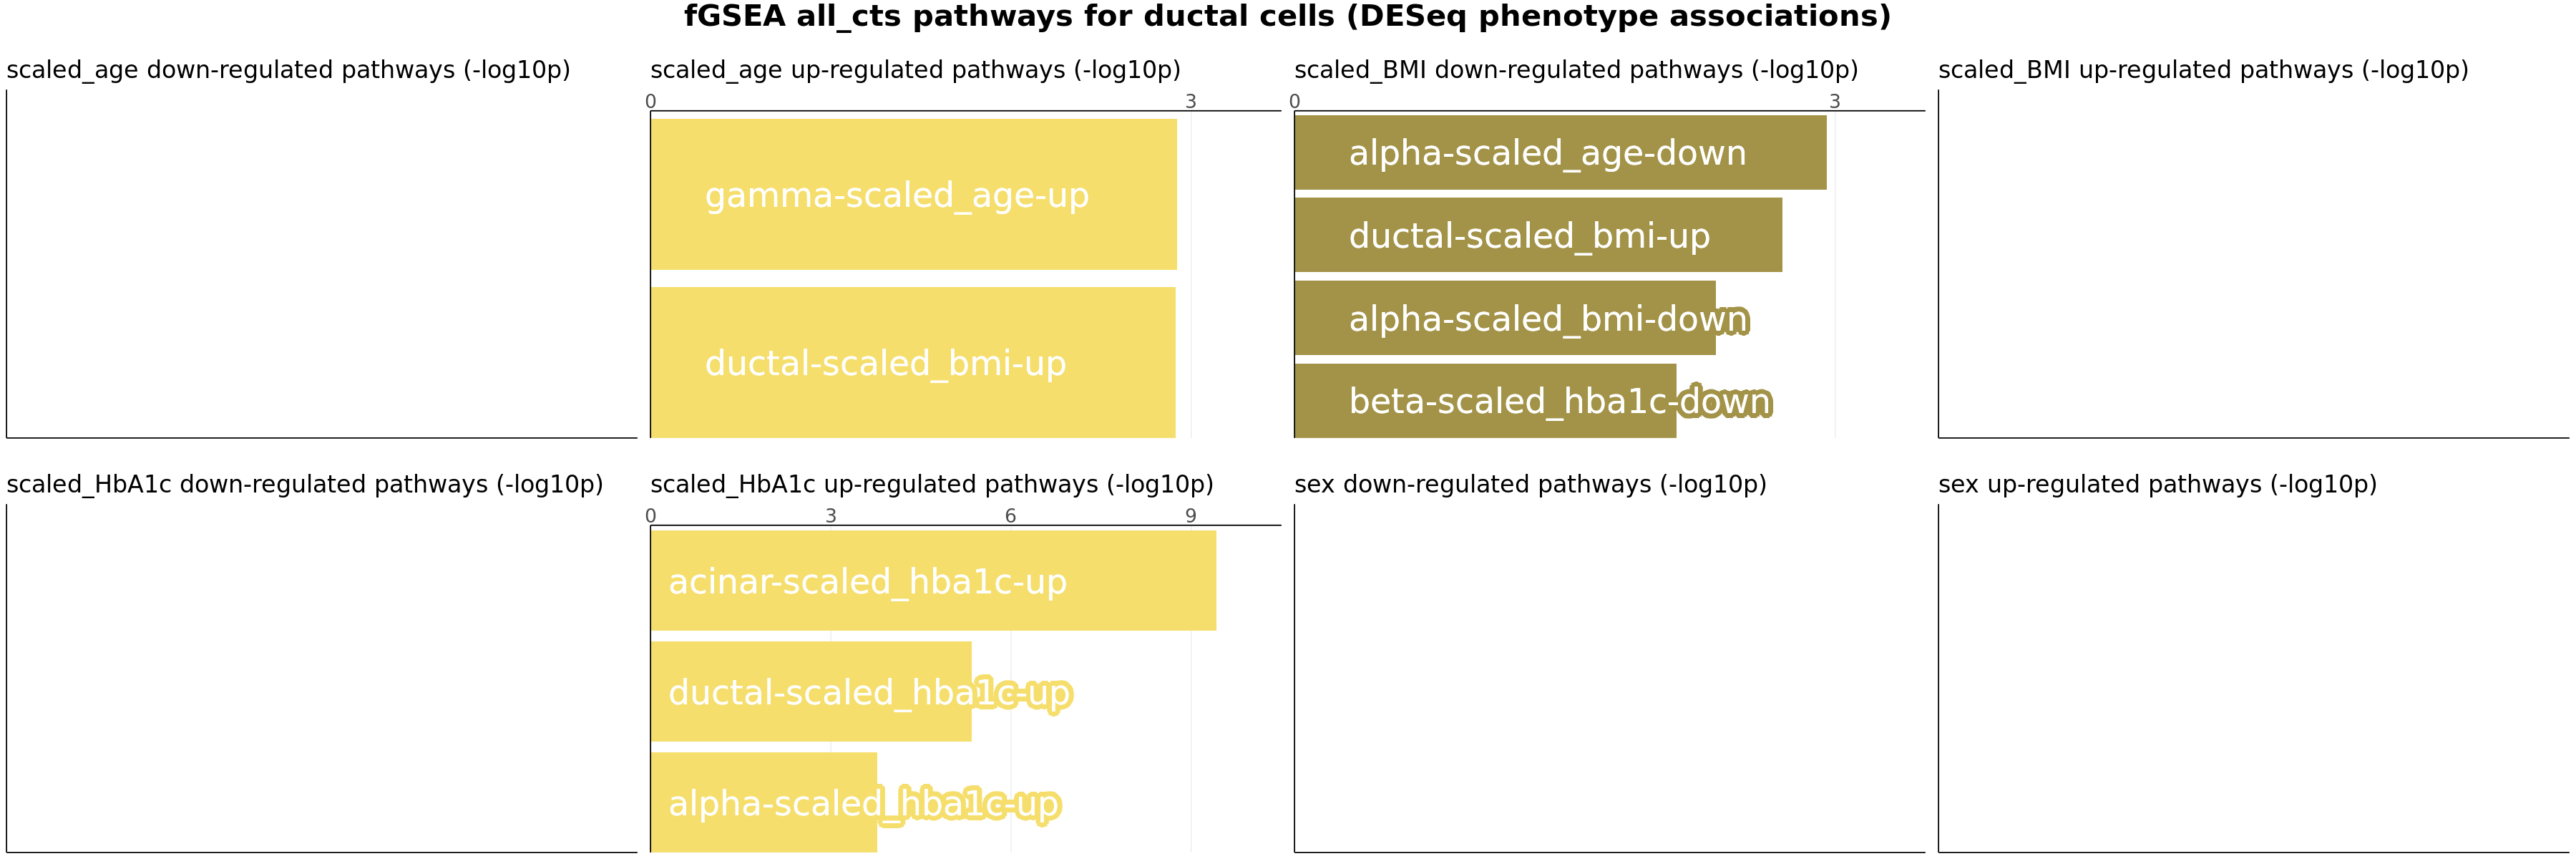

In [41]:
for (celltype in rna_celltypes){
    make_ct_pathway_plots(celltype, traits, fgsea_outdir, 'all_cts', 0.1, colors)
}

## Summarize all results as heatmaps

In [42]:
### Function so I can run this easily on all 3 different linked genes sets
plot_comp_heatmap <- function(results, pathways_name, assoc_order, pathway_order){
    rna_pal <- c('#D73027','#E6938E','#F5F5F5','#94B5E1','#3375CC')
    options(repr.plot.width=24, repr.plot.height=12)
    theme_set(
        theme_classic())
    
    p1 <- ggplot(results, aes(x=pathway, y=deseq_res, fill=rank, label=sig)) +
            geom_tile(color='white') + 
            scale_fill_gradient2(low = rna_pal[5], mid = rna_pal[3], high = rna_pal[1]) + 
            geom_text(aes(label=sig, x=pathway, y=deseq_res), color='black', vjust=0.65, size=8) + 
            ylab('DESeq results') + xlab('Linked genes pathway') + ggtitle(sprintf('fGSEA of %s linked genes in RNA REM results',pathways_name)) +
            theme(axis.title=element_text(size=20),
                  axis.text.x=element_text(size=15,angle=30, hjust=1),
                  axis.text.y=element_text(size=15),
                  axis.ticks.length=unit(0.25,'cm'),
                  legend.title=element_text(size=15),
                  legend.text=element_text(size=15),
                  legend.key.size=unit(0.75,'cm'),
                  panel.border=element_rect(color='black',fill=NA, size=1))
    p1$data$deseq_res = factor(x=p1$data$deseq_res,levels=rev(assoc_order))
    p1$data$pathway = factor(x=p1$data$pathway,levels=pathway_order)
    p1$data$celltype = factor(x=p1$data$celltype,levels=rna_celltypes)
    p1$data$celltype2 = factor(x=p1$data$celltype2,levels=rna_celltypes)
    p1 + facet_grid(celltype ~ celltype2, scales='free')
}

In [43]:
### Wrapper for heatmap function
comp_heatmap_wrapper <- function(celltypes, traits, pathways_name, padj_cutoff=0.1, pval_cutoff=0.05){
    results <- data.frame()
    for(trait in traits){
        for(celltype in celltypes){
            fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
            df <- as.data.frame(fread(fp))
            df <- df %>% select(-leadingEdge)
            df$deseq_res <- paste(celltype,trait,sep='-')
            df$celltype <- celltype
            results <- rbind(results, df)
        }
    }
    results$pval[results$pval<1e-10] <- 1e-10
    results$sign_logp <- -log10(results$pval) * sign(results$NES)
    results$rank <- -log10(results$pval) * results$NES
    results$sig <- ifelse(results$padj < 0.1, '*',ifelse(results$pval<0.05,'\u00b0',''))
    results$celltype2 <- str_split_fixed(results$pathway,'-',3)[,1]

    #inputs for heatmap
    gmt_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/linked_gene_fGSEA/gmt_files'
    pathway_order <- fread(file.path(gmt_dir,'all_cts_trait_assoc_nom_peak_linked_genes.gmt'), fill=TRUE)$V1
    assoc_order <- paste(rep(rna_celltypes,each=4),traits,sep='-')
    
    #make heatmap!
    print(plot_comp_heatmap(results, pathways_name, assoc_order, pathway_order))
}

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


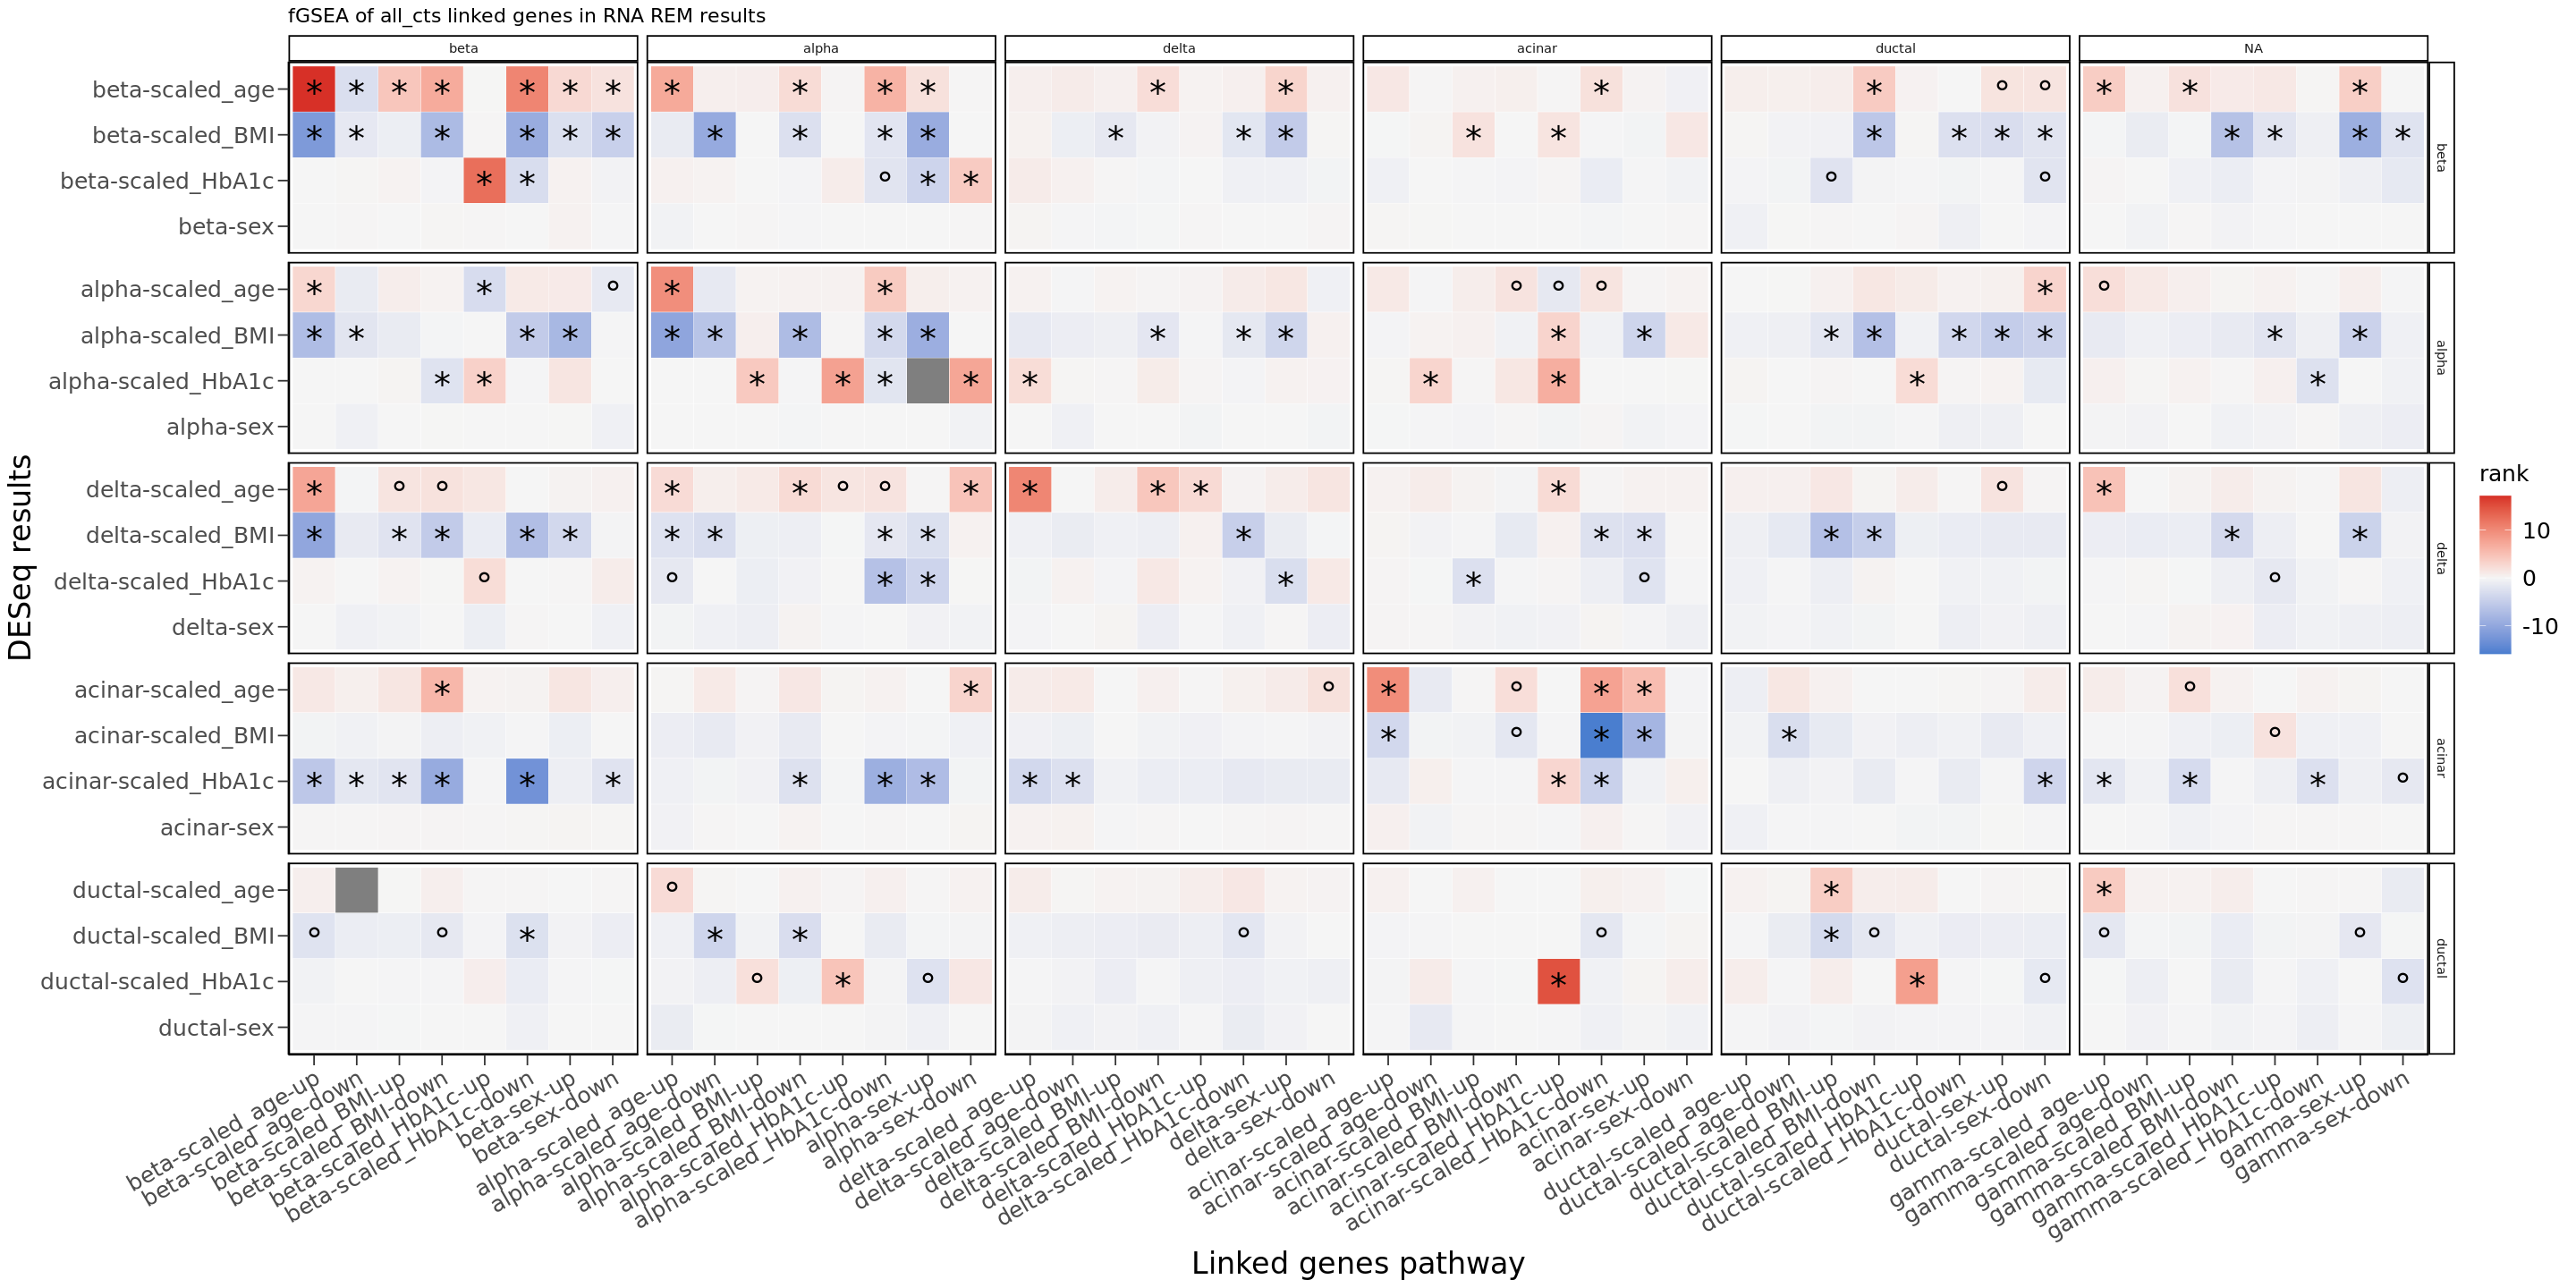

In [44]:
comp_heatmap_wrapper(rna_celltypes[seq(5)], traits, 'all_cts')